<img src='ONCFM_logo.png'>

# Sommaire

1. [Environnement de travail](#chapter1)  
    1.1. [Import des librairies](#section1_1)  
    1.2. [Import des fonctions](#section1_2)  
2. [Préparation des données](#chapter2)  
    2.1. [Création du dataframe](#section2_1)  
    2.2 [Traitement des Valeurs manquantes](#section2_2)  
3. [Analyse descriptive des données](#chapter3)  
4. [Modélisation](#chapter4)  
    4.1. [Normalisation des données](#section4_1)  
    4.2. [Analyse en Composantes Principales](#section4_2)  
    4.3. [Classification Ascendante Hiérarchique](#section4_3)  
    4.4. [Algorithme du K-Means](#section4_4)  
    4.4. [Régression logistique](#section4_5)  
5. [Sauvegarde du modèle](#chapter5)
6. [Mise en service du modèle de Régression Logistique](#chapter6)

# 1. Environnement de travail<a class='anchor' id='chapter1'></a>
## 1.1. Import des librairies et paramètrage<a class='anchor' id='section1_1'></a>

In [1]:
import pandas as pd
import numpy as np

# librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# librairies statistiques
import statsmodels.stats as st
from scipy.stats import shapiro, levene, probplot, t

# librairies de modélisation et ML
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing, cluster, metrics, decomposition

# pour ne pas afficher les messages d'avertissement
import warnings
warnings.filterwarnings("ignore")

Nous utiliserons une palette de couleurs rouge/vert pour distinguer les billets.  
Les tests statistiques seront effectués au seuil de 5%.

In [2]:
# couleurs des graphes
colours = {'red', 'green'}
sns.set_palette(colours)

# taille des figures
plt.rcParams["figure.figsize"] = (15, 10)

# valeur de test
ALPHA = 0.05

## 1.2. Import des fonctions<a class='anchor' id='section1_2'></a>

In [3]:
def infosurdf(df):
    
    '''fonction describe() avec en plus :
    - le type de la colonne 
    - le nombre de valeurs manquantes'''
    d1 = pd.DataFrame(df.dtypes).T.rename(index={0: "type de la colonne"})
    d2 = pd.DataFrame(df.isnull().sum()).T.rename(index={0: "nombre de valeurs NaN"})
    d3 = df.describe()
    return pd.concat([d1, d2, d3])

def matrice_corr(df):
    
    '''merci à Josué Afouda
    matrice de corrélation sous forme triangulaire'''
    #plt.figure(figsize=(15, 10))
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, center=0, cmap='RdBu', 
                linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
    plt.title('Carte des corrélations', fontsize = 15, fontweight='bold')
    plt.show()
    
# merci à Nicolas Rangeon

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), pcs[d1, :], pcs[d2, :],
                       angles='xy', scale_units='xy', scale=1, color="grey")
                        
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontsize=16, fontweight='bold')
    
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], cmap=colours, alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:,[d1, d2]]):
                    plt.text(x, y, labels[i], fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=16, fontweight='bold')
            

def display_scree_plot(pca, kaiser):
    scree = pca.explained_variance_ratio_*100
            
    #plt.figure(figsize=(15, 10))
    plt.bar(np.arange(len(scree))+1, scree, color="blue")
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.axhline(y=kaiser, color='black', linestyle='--')
    plt.xticks(np.arange(len(scree))+1)
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres", fontsize=16, fontweight='bold')
    plt.show()
    
    pd.set_option('display.width', None)
    scree_cum = (pca.explained_variance_ratio_*100).cumsum()
    scree_cum = pd.DataFrame(data=scree_cum, index=np.arange(len(scree))+1, columns=['Cumul de variance expliquée']).T
    print(scree_cum)

# 2. Préparation des données<a class='anchor' id='chapter2'></a>
## 2.1. Création du dataframe <a class='anchor' id='section2_1'></a>

Lors de leur fabrication par planches, les billets sont d'abord découpés dans la longueur.  
Des décalages peuvent entraîner des différences dans les hauteurs à droite et à gauche.

In [4]:
df = pd.read_csv('billets.csv', sep=';')
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

Nous remarquons que les valeurs de la diagonale ne répondent pas aux valeurs attendues par le théorème de Pythagore (~150 mm).

In [5]:
infosurdf(df)

is_genuine   diagonal height_left height_right  \
type de la colonne          bool    float64     float64      float64   
nombre de valeurs NaN          0          0           0            0   
count                        NaN     1500.0      1500.0       1500.0   
mean                         NaN  171.95844  104.029533   103.920307   
std                          NaN   0.305195    0.299462     0.325627   
min                          NaN     171.04      103.14       102.82   
25%                          NaN     171.75      103.82       103.71   
50%                          NaN     171.96      104.04       103.92   
75%                          NaN     172.17      104.23       104.15   
max                          NaN     173.01      104.88       104.95   

                      margin_low margin_up    length  
type de la colonne       float64   float64   float64  
nombre de valeurs NaN         37         0         0  
count                     1463.0    1500.0    1500.0  
mean                    4.485967  3.151473  112.6785  
std                     0.663813  0.231813   0.87273  
min                         2.98      2.27    109.49  
25%                        4.015      2.99    112.03  
50%                         4.31      3.14    112.96  
75%                         4.87      3.31    113.34  
max                          6.9      3.91    114.44

La première colonne correspond à une variable qualitative (l'authenticité du billet), les autres variables sont toutes quantitatives (dimensions en mm).  
Les décalages entre les hauteurs peuvent-ils permettre une distinction entre vrais et faux billets?

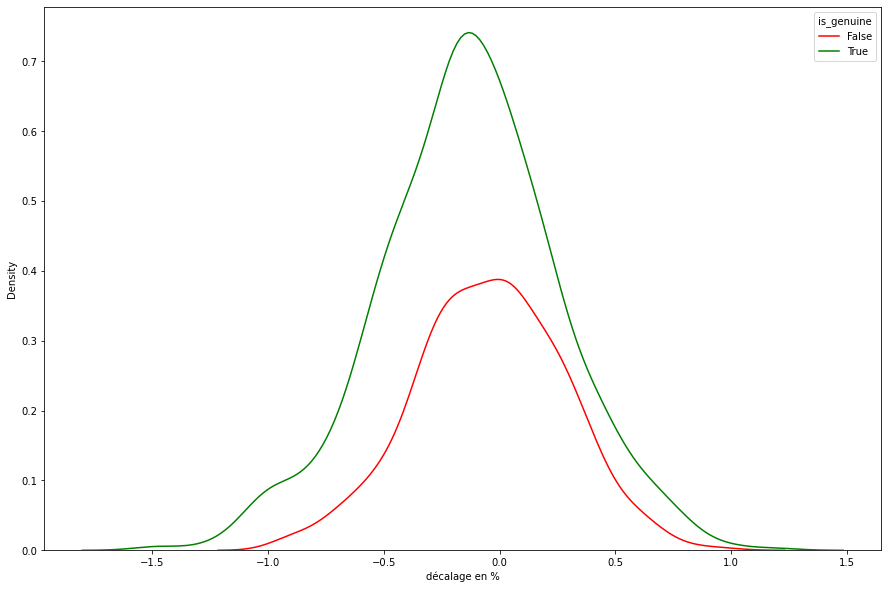

In [6]:
df["décalage en %"] = (df.height_right - df.height_left) * 100/ df.height_left
sns.kdeplot(data=df, x="décalage en %", hue="is_genuine");

Il n'y a pas de différence notable entre les variations dans les hauteurs droite et gauche. Les faussaires utilisent un matériel performant dans la découpe des billets.

In [7]:
df = df.drop(columns="décalage en %")

In [8]:
df.duplicated().value_counts()

False    1500
dtype: int64

Notre jeu de données ne contient pas de doublons.

## 2.2. Traitement des Nan<a class='anchor' id='section2_2'></a>
Nous notons 37 valeurs manquantes pour la colonne "margin_low".  
Plusieurs méthodes peuvent être utilisées : 
* suppression des lignes concernées (2.5% de nos données), 
* remplacement par la moyenne ou la médiane,
* prédiction par régression linéaire.

### 2.2.1. Régression Linéaire Multiple
Dans le cadre de ce projet, nous utiliserons la Régression Linéaire.  
Nous créons un df sans valeurs manquantes et un avec uniquement les 37 lignes concernées.

In [9]:
# dataframe des 37 lignes contenant un Nan
df_nan = df[df["margin_low"].isna()]

# dataframe des autres lignes
df2 = df[~(df["margin_low"].isna())]

Nous utilisons la méthode lm pour régresser margin_low en fct des autres variables de l'échantillon sur notre dataframe sans Nan.  
Nous testerons ensuite ce modèle sur l'autre df pour en prédire les valeurs manquantes.

In [10]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df2).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          2.60e-202
Time:                        14:07:21   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Tous les paramètres sont significatifs, les p-valeur sont inférieures à 5 % (niveau de test souhaité).  
Le coefficient de détermination $\ R²$ vaut environ 0.48. Pour mémoire, $\ R²$ tend à surévaluer la qualité de la régression linéaire.

$$\ R² = 1 - \frac{{SCR}}{{SCT}}\ $$  
La mesure $\ R²$ ajusté tente de corriger cette surévaluation.

$$\ R²_{ajusté} = {R²} - \frac{{k(1 - {R²})}}{{n - k - 1}}\ $$

ressource utilisée : https://www.youtube.com/watch?v=VRazQ101XyU

### 2.2.2. Colinéarité des variables
La note 2 semble indiquer la possibilité d'une colinéarité de nos variables. Nous pouvons le vérifier grâce au facteur d'influence de la variance.

In [11]:
# 1e méthode : méthode de Eric Rakotomalala

# création du df contenant uniquement les variables explicatives
df_vif = df2.drop(columns={"is_genuine", "margin_low"})

# matrice de corrélation
mc = df_vif.corr()
# la matrice est inversée
vif = np.linalg.inv(mc)
# les vif sont contenus dans la diagonale de la matrice
np.diag(vif)

array([1.0136129 , 1.13826057, 1.23011452, 1.40440378, 1.57695015])

In [12]:
# 2e méthode
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686293,
 1.1382605736082496,
 1.2301145155560385,
 1.4044037781843617,
 1.5769501453665846]

exog : les variables explicatives  
endog : la variable à expliquer  
Dans ce cas, les facteurs d'inflation de la variance sont inférieurs à 4, il n'y a pas de problème de colinéarité.

### 2.2.3. Normalité des résidus
Etudions la distribution des résidus de notre régression

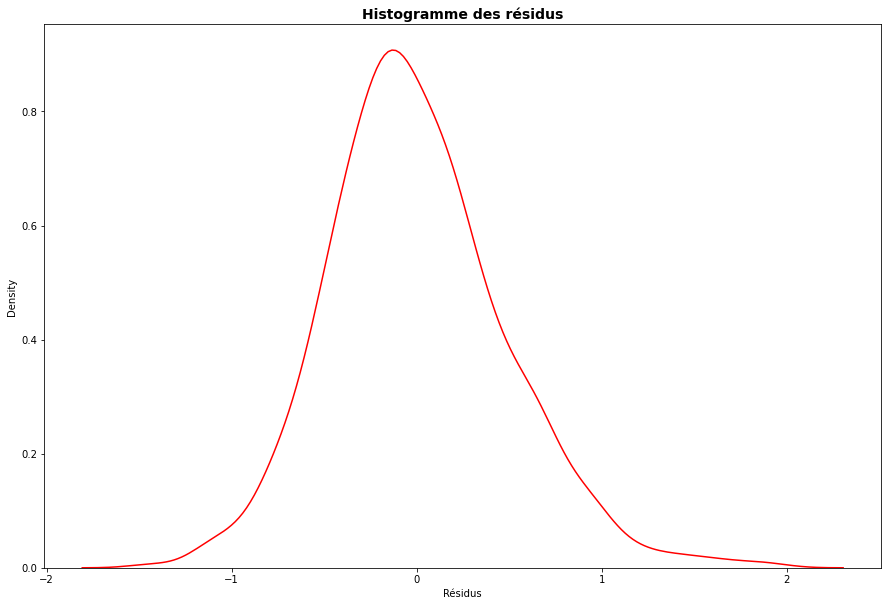

In [13]:
sns.kdeplot(reg_multi.resid)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus', fontsize=14, fontweight='bold')
plt.show()

In [14]:
stat, pval = shapiro(reg_multi.resid)
H0 = "l'hypothèse H0 ne peut pas être rejetée" if pval > ALPHA else "l'hypothèse H0 est rejetée"
print("la pvalue est de",round(pval, 2), H0, "au seuil de", ALPHA*100, "%")

la pvalue est de 0.0 l'hypothèse H0 est rejetée au seuil de 5.0 %


Malgré sa forme en cloche, le test de Shapiro-Wilk nous indique que les résidus ne suivent pas une loi normale.

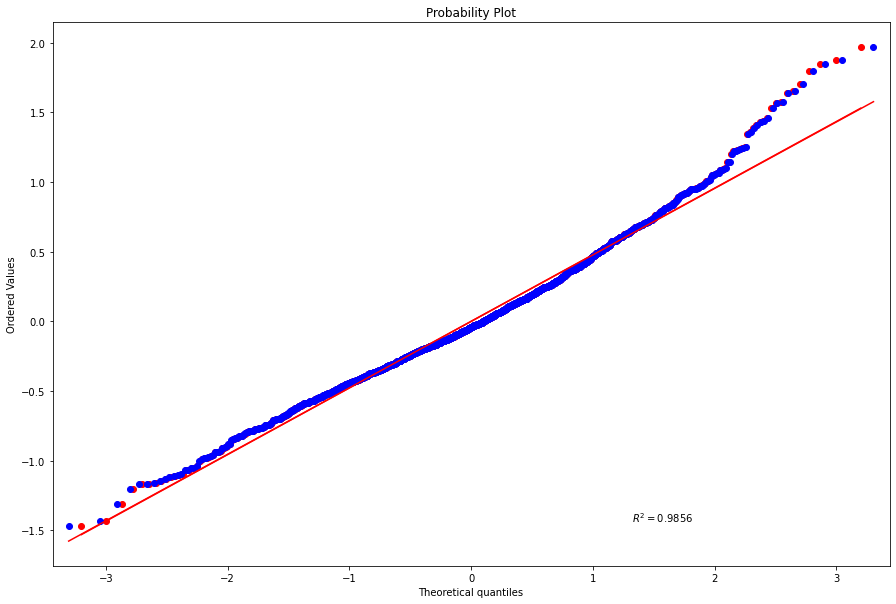

In [15]:
# droite de Henry, Q-Qnorm

sm.qqplot(reg_multi.resid, line='r')
probplot(reg_multi.resid, dist='norm', plot=plt, rvalue=True);

Les résidus suivent une distribution gaussienne à 98.5% (résultat en accord avec la valeur de la probabilité de Jarque-Bera)  
(Les 2 courbes sont confondues)

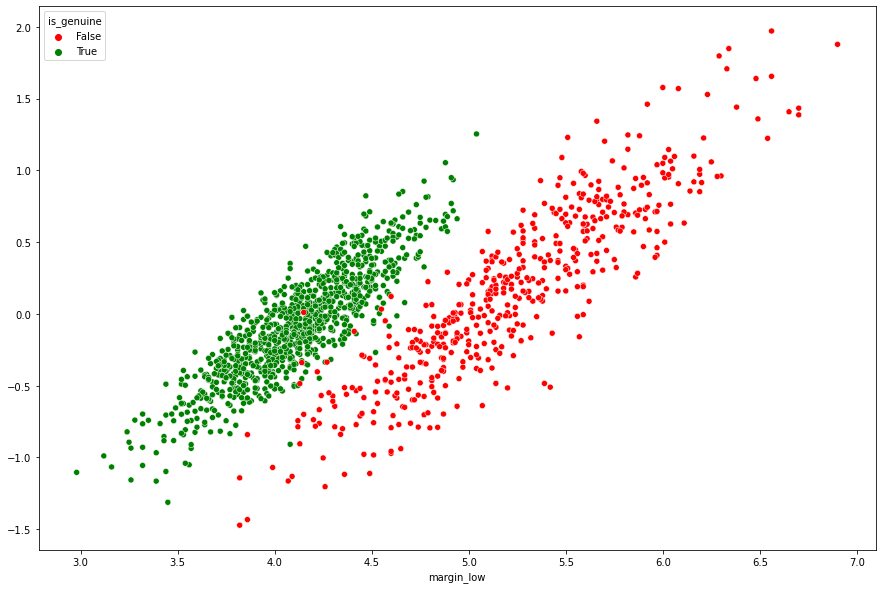

In [16]:
# graphique des résidus avec la variable endogène et les variables exogènes
df2 = df2.reindex(columns=['is_genuine', 'margin_low', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

fig = sns.scatterplot(x = df2.margin_low, y = reg_multi.resid, hue=df2["is_genuine"]);

Pour la variable endogène, les faibles valeurs tendent à être sousestimées (residus négatifs) tandis que les valeurs élevées tendent à être surestimées (résidus positifs).

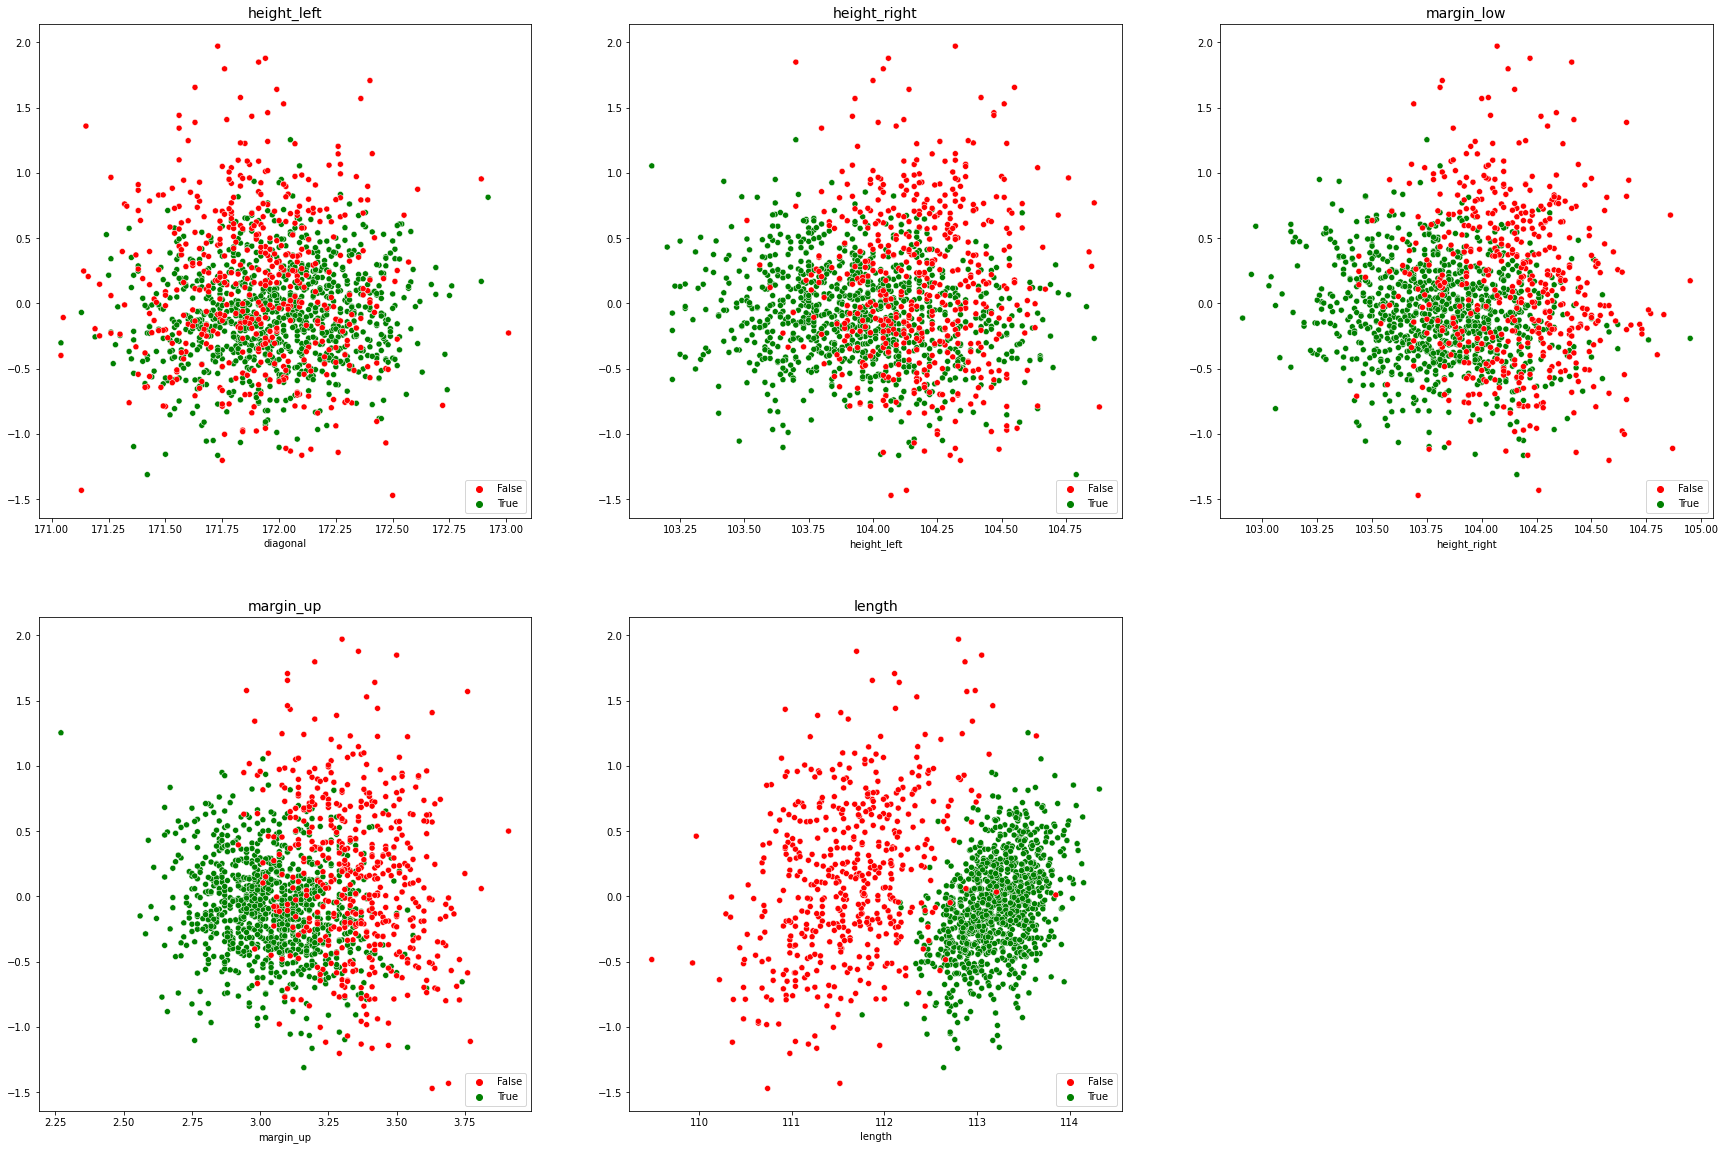

In [17]:
# graphique des résidus avec les variables exogènes

fig = plt.figure(figsize=(30, 20))
for j in range(2,7):
    ax = fig.add_subplot(2, 3, (j-1))
    ax = sns.scatterplot(x = df2.iloc[:,j], y = reg_multi.resid, hue=df2["is_genuine"])
    ax.set_title(df.columns[j], fontsize=14)
    ax.legend(loc="lower right");

### 2.2.4. Détection des points atypiques ou influents
Nous calculons les leviers et les résidus studentisés

In [18]:
# affichage des leviers et des résidus studentisés
infl = reg_multi.get_influence()
infl_df = infl.summary_frame().filter(["hat_diag", "student_resid"])
infl_df

hat_diag  student_resid
0     0.016606      -0.563461
1     0.006015      -0.769603
2     0.008298       0.572356
3     0.004467      -1.118778
4     0.005558      -1.121157
...        ...            ...
1495  0.004307      -1.609702
1496  0.005672      -0.389751
1497  0.001643       1.269639
1498  0.002254       0.752565
1499  0.003324      -0.435427

[1463 rows x 2 columns]

Ces valeurs peuvent être représentées dans un nuage de points : plus l'abscisse est élevée plus le point est différent des autres dans l'espace des descripteurs (billet d'index 0, *e.g.*). En ordonnées plus les valeurs sont éloignées de 0, moins les points sont bien modélisés.  
La taille des points est basée sur la distance de Cook : estimation de l'influence d'une donnée lors de l'utilisation de méthodes des moindres carrés. Plus le point est gros, plus il influe sur la régression.

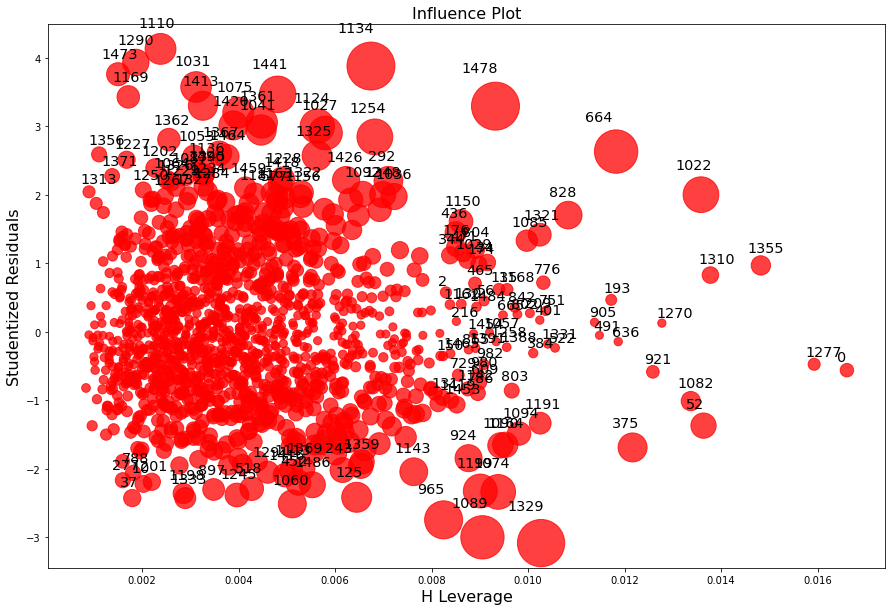

In [19]:
# représentation graphique, la taille des points est donnée par la distance de Cook
sm.graphics.influence_plot(reg_multi);

<u>Récupération des valeurs atypiques au sens du levier</u>  
Un point pose problème si sa valeur de levier est 2 fois celle de la moyenne des leviers

In [20]:
# nombre d'observations : 1463
n = df2.shape[0]
# nombre de variables explicatives : 6
p = df2.shape[1] - 1

#levier des observations
levier = infl.hat_matrix_diag

#seuil
seuil_levier = 2 * (p+1)/n
seuil_levier

0.009569377990430622

In [21]:
# calcul valeurs atypiques levier
atyp_levier = levier > seuil_levier
print("Liste par index des valeurs atypiques (levier) :\n", df2.index[atyp_levier])

# résultat conservé dans un df pour la représentation
lev_infl_df2 = infl_df[infl_df.index.isin(df2.index[atyp_levier])]

Liste par index des valeurs atypiques (levier) :
 Int64Index([   0,   52,  193,  209,  375,  384,  401,  491,  522,  636,  664,
             751,  776,  802,  803,  828,  842,  905,  921, 1022, 1082, 1085,
            1094, 1191, 1270, 1277, 1310, 1321, 1329, 1331, 1355],
           dtype='int64')


<u>Récupération des valeurs atypiques au sens des résidus studentisés</u>  
Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [22]:
# résidus studentisés des observations
rstud = infl.resid_studentized_external

# seuil
seuil_rstud = t.ppf(1-ALPHA, df=n-p-1)
seuil_rstud

1.645900841941544

In [23]:
# calcul valeurs atypiques résidus studentisés
atyp_rstud = np.abs(rstud) > seuil_rstud
print("Liste par index des valeurs atypiques (résidus studentisés) :\n", df2.index[atyp_rstud])

# résultat conservé dans un df pour la représentation
rstud_infl_df2 =  infl_df[infl_df.index.isin(df2.index[atyp_rstud])]

Liste par index des valeurs atypiques (résidus studentisés) :
 Int64Index([  10,   37,   80,  125,  149,  182,  201,  243,  255,  260,
            ...
            1441, 1459, 1463, 1464, 1473, 1475, 1478, 1480, 1486, 1490],
           dtype='int64', length=139)


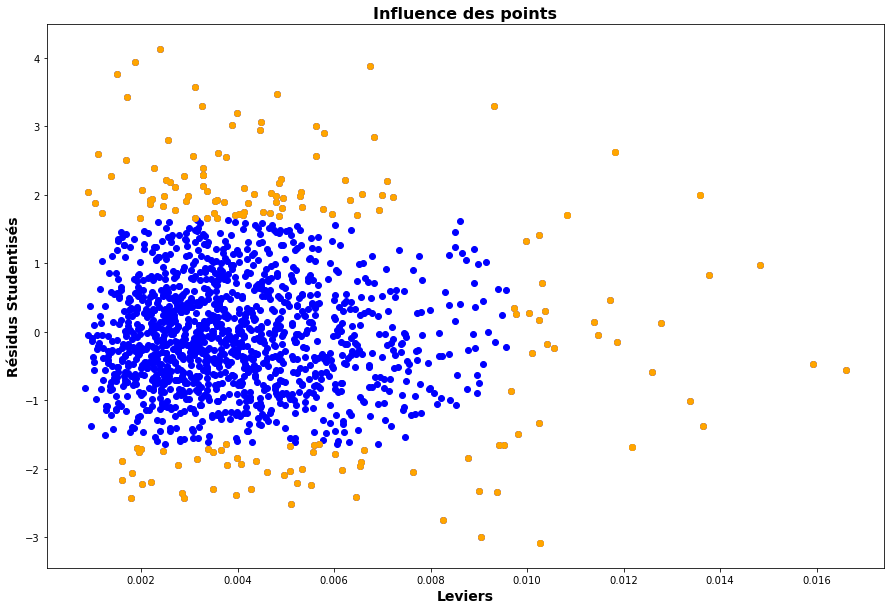

In [24]:
plt.scatter(data=infl_df, x="hat_diag", y="student_resid", c='blue')
plt.scatter(data=lev_infl_df2, x="hat_diag", y="student_resid", c='orange')
plt.scatter(data=rstud_infl_df2, x="hat_diag", y="student_resid", c='orange')
plt.xlabel("Leviers", fontsize=14, fontweight='bold')
plt.ylabel("Résidus Studentisés", fontsize=14, fontweight='bold')
plt.title("Influence des points", fontsize=16, fontweight='bold');

Nous pourrions rajouter la distance de Cook pour les valeurs influentes mais les plus influentes sont aussi des atypiques.

In [93]:
# critère de sélection des valeurs atypiques
critere = np.logical_or(atyp_levier, atyp_rstud)
df2_clean = df2.iloc[np.logical_not(critere), 0:7]

Nous pouvons réentraîner notre modèle sur ce jeu de données :

In [94]:
reg_multi2 = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df2_clean).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          2.60e-202
Time:                        14:11:46   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Les valeurs du $ R²$ sont les mêmes. Nous avons utilisé ce modèle pour la prédiction et les modélisations. Nous obtenons les mêmes résultats pour le K-Means et la Régression Logistique, ce modèle améliore les performances de la CAH.

### 2.2.5. Utilisation du modèle
Ce modèle peut donc être utilisé pour prédire les valeurs manquantes

In [28]:
margin_low_pred = round(reg_multi.predict(df_nan),2)

Nous remplaçons les valeurs manquantes par ces valeurs prédites

In [29]:
df_nan["margin_low"] = margin_low_pred

Nous faisons la concaténation des 2 df

In [30]:
df = pd.concat([df2, df_nan])

Nous pouvons vérifier que ce df ne contient plus de valeurs manquantes et autant de lignes que le df initial

In [31]:
infosurdf(df)

is_genuine margin_low   diagonal height_left  \
type de la colonne          bool    float64    float64     float64   
nombre de valeurs NaN          0          0          0           0   
count                        NaN     1500.0     1500.0      1500.0   
mean                         NaN    4.48348  171.95844  104.029533   
std                          NaN   0.659643   0.305195    0.299462   
min                          NaN       2.98     171.04      103.14   
25%                          NaN       4.02     171.75      103.82   
50%                          NaN       4.31     171.96      104.04   
75%                          NaN       4.87     172.17      104.23   
max                          NaN        6.9     173.01      104.88   

                      height_right margin_up    length  
type de la colonne         float64   float64   float64  
nombre de valeurs NaN            0         0         0  
count                       1500.0    1500.0    1500.0  
mean                    103.920307  3.151473  112.6785  
std                       0.325627  0.231813   0.87273  
min                         102.82      2.27    109.49  
25%                         103.71      2.99    112.03  
50%                         103.92      3.14    112.96  
75%                         104.15      3.31    113.34  
max                         104.95      3.91    114.44

# 3. Analyse descriptive des données<a class='anchor' id='chapter3'></a>

## 3.1. Proportion entre vrais et faux billets

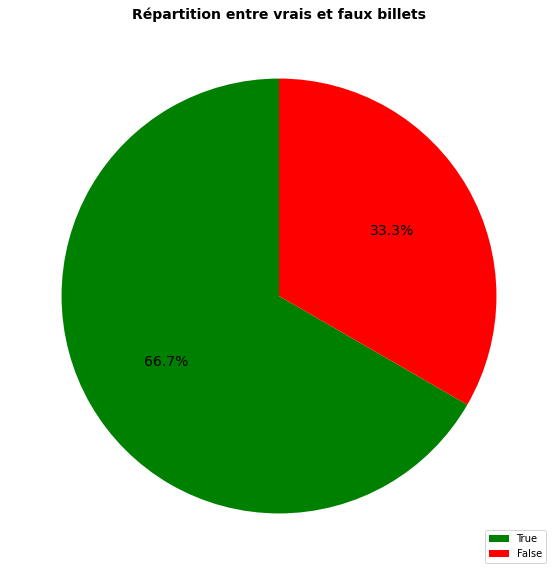

In [32]:
proportion = df["is_genuine"].value_counts()
plt.pie(proportion, colors=['green', 'red'], autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
plt.legend(df["is_genuine"].unique(), loc='lower right')
plt.title("Répartition entre vrais et faux billets", fontsize=14, fontweight='bold');

Nous observons un déséquilibre dans les effectifs de classe.  
Nous devrons en tenir compte lors des tests de performance des modèles.

## 3.2. Distribution et nuages de points

Un pairplot peut-être réalisé pour visualiser les nuages de points d'une variable en fct des 5 autres.  
La variable par elle-même nous donne l'allure de sa distribution.

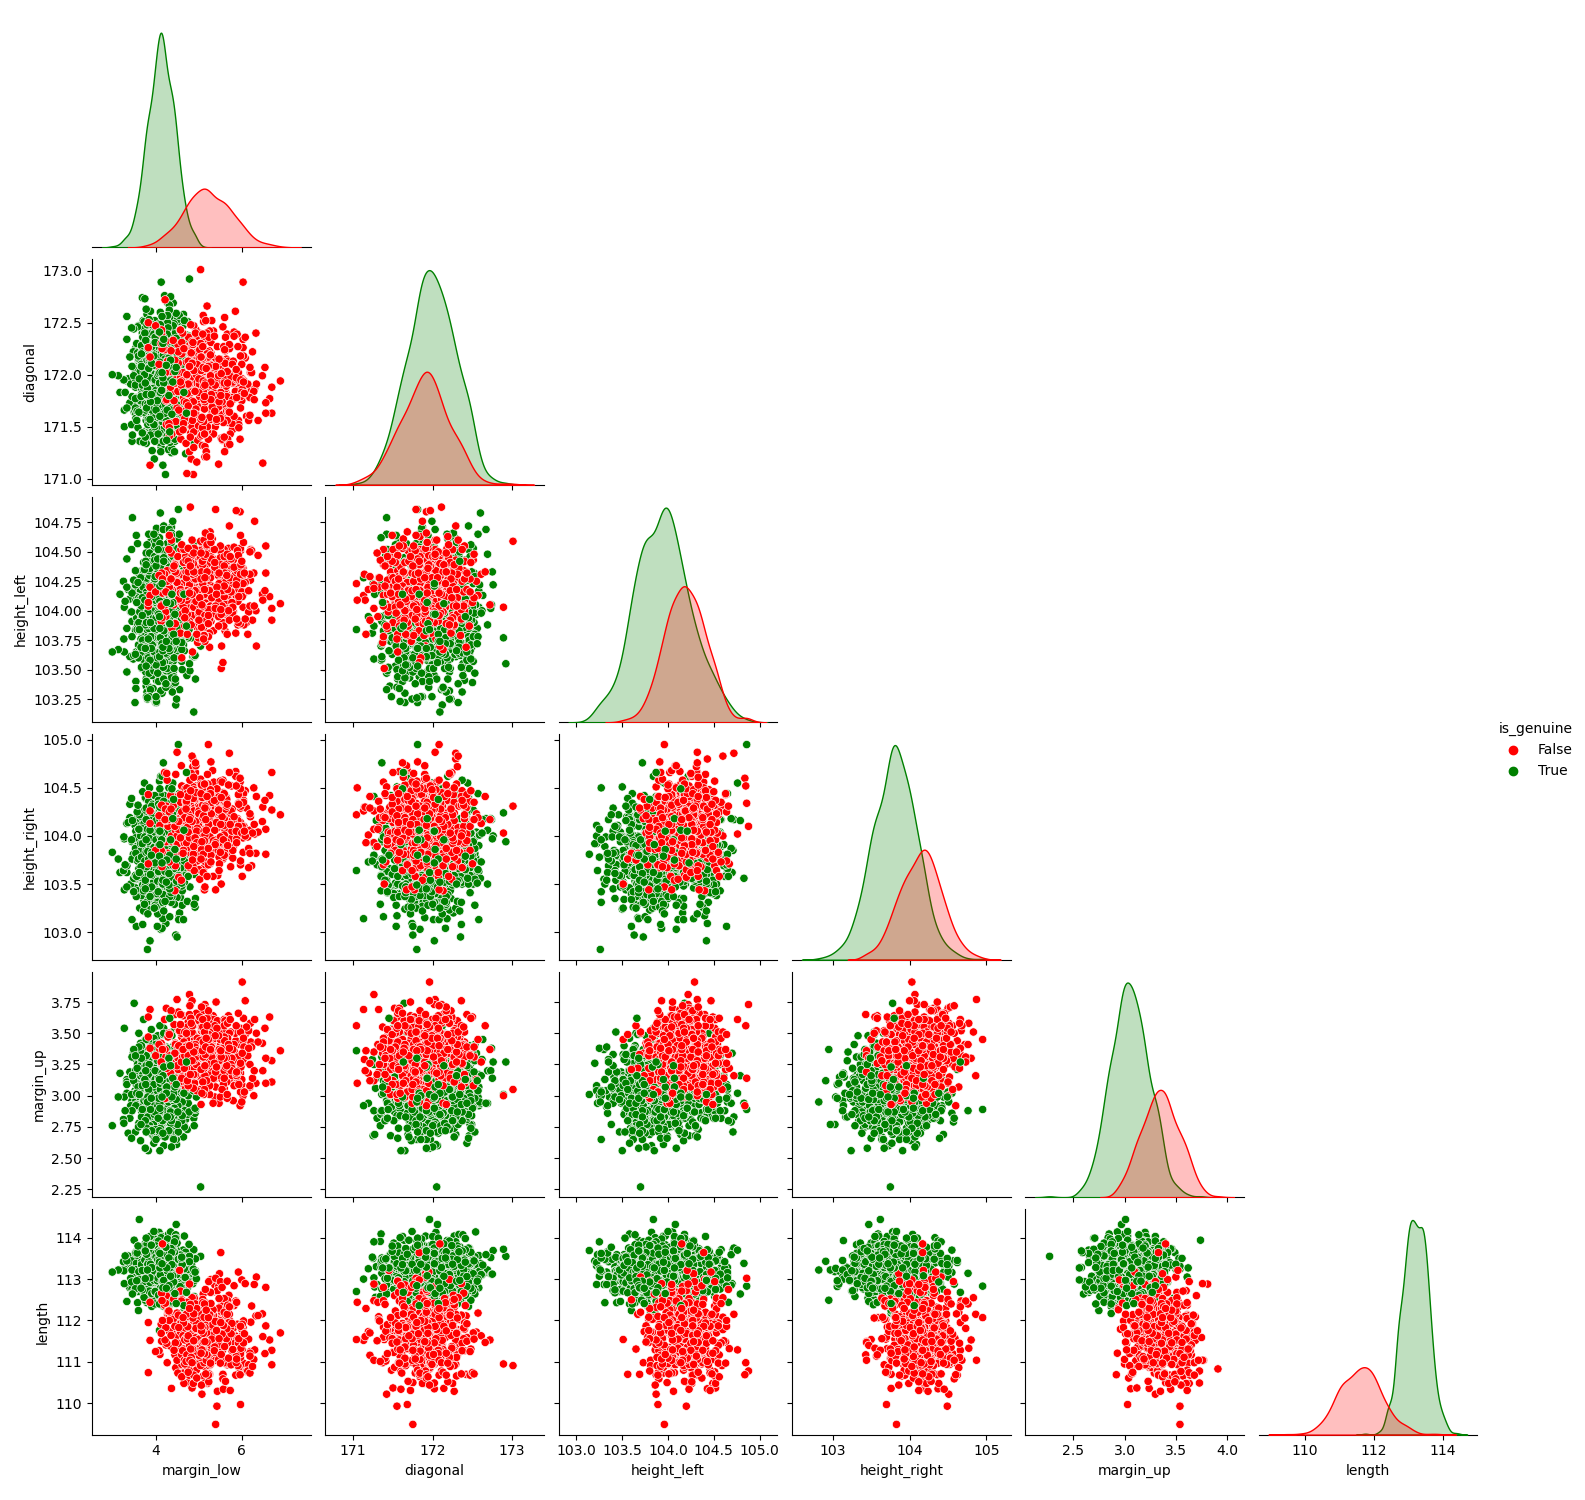

In [95]:
sns.pairplot(df, hue='is_genuine', corner=True);

Les distributions des longueurs et des marges basses sont bien distinctes selon l'authenticité du billet. Le nuage de points correspondant à ces 2 variables fait apparaitre 2 clusters distincts. Ces 2 variables seront utiles à notre modélisation.

Nous pouvons d'ors et déjà tester la normalité de chaque distribution

In [34]:
shap = []

for column in df:
    for i in[True, False]:
        dft = df[df["is_genuine"] == i]
        stat, pval = shapiro(dft[column])
        H0 = "Hypothèse non rejetée" if pval > ALPHA else "Hypothèse rejetée"
        shap.append((i, column, stat, pval, H0))
pd.DataFrame(shap, columns=("Authenticité du billet", "Dimension", "Stat", "p-value", "Hypothèse")).set_index("Dimension").drop(["is_genuine"])

Authenticité du billet      Stat   p-value  \
Dimension                                                  
margin_low                      True  0.998284  0.422109   
margin_low                     False  0.997032  0.501442   
diagonal                        True  0.998066  0.311489   
diagonal                       False  0.997436  0.639055   
height_left                     True  0.996583  0.028626   
height_left                    False  0.997877  0.790663   
height_right                    True  0.998548  0.586224   
height_right                   False  0.997990  0.826578   
margin_up                       True  0.998157  0.354887   
margin_up                      False  0.995734  0.192689   
length                          True  0.998046  0.302287   
length                         False  0.997111  0.527232   

                          Hypothèse  
Dimension                            
margin_low    Hypothèse non rejetée  
margin_low    Hypothèse non rejetée  
diagonal      Hypothèse non rejetée  
diagonal      Hypothèse non rejetée  
height_left       Hypothèse rejetée  
height_left   Hypothèse non rejetée  
height_right  Hypothèse non rejetée  
height_right  Hypothèse non rejetée  
margin_up     Hypothèse non rejetée  
margin_up     Hypothèse non rejetée  
length        Hypothèse non rejetée  
length        Hypothèse non rejetée

Seule la distribution des données de la variable "height_left" pour les vrais billets ne suit pas une loi normale.

In [35]:
print("coef d'asymétrie:", round(df["height_left"][df["is_genuine"] == True].skew(),2),"coef de kurtosis :", round(df["height_left"][df["is_genuine"] == True].kurtosis(),2))

coef d'asymétrie: 0.15 coef de kurtosis : -0.12


Cette distribution est tout de même très symétrique, son kurtosis indique des valeurs extrèmes plus nombreuses (kurtosis de loi normale corrigé à 0 et non 3 par ce calcul). Elle reste mésokurtique.
## 3.3. Boxplots

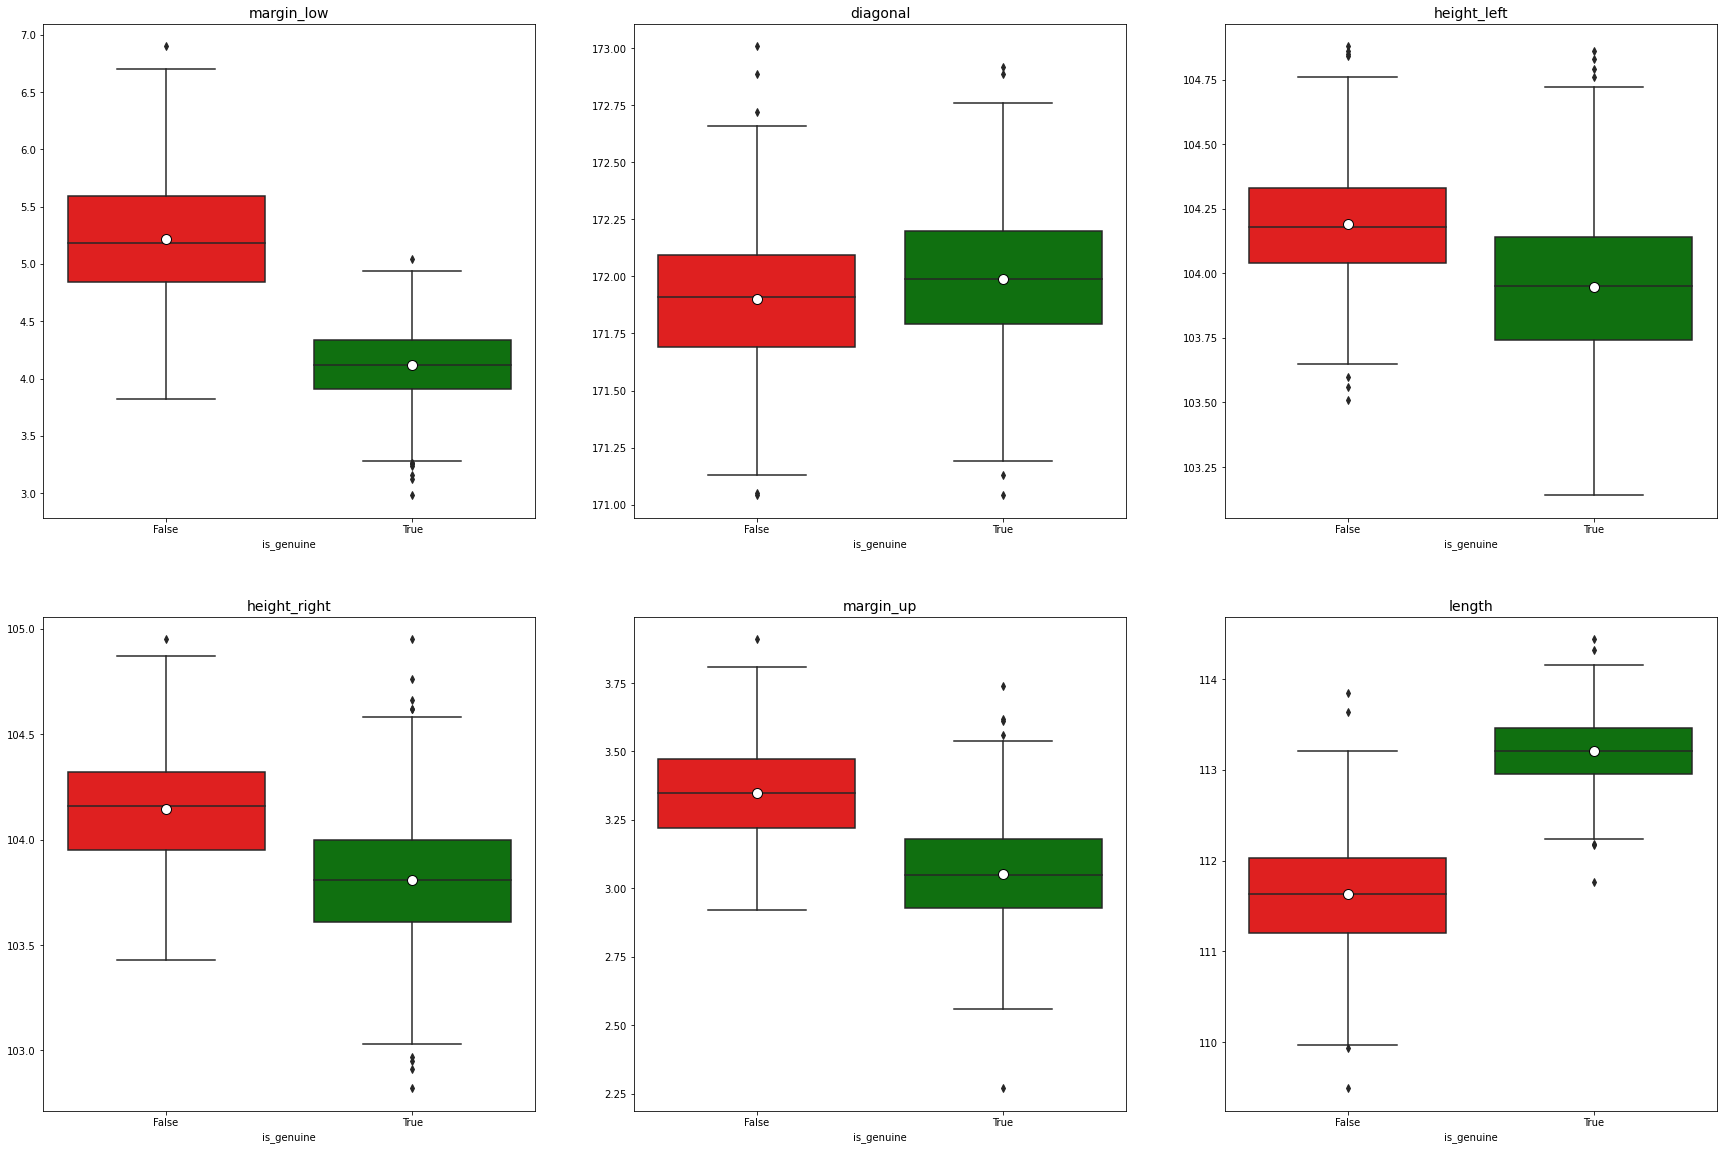

In [36]:
k = df[df.columns[1:]].values

# boxplot de chaque indicateur
fig = plt.figure(figsize=(30, 20))
for feat_idx in range(k.shape[1]):
    ax = fig.add_subplot(2, 3, (feat_idx+1))
    ax = sns.boxplot(data=df, y=k[:, feat_idx],
                     showmeans = True,
                     x='is_genuine', 
                     meanprops={"marker":"o",
                                "markerfacecolor":"white", 
                                "markeredgecolor":"black",
                                "markersize":"10"})
    ax.set_title(df.columns[feat_idx+1], fontsize=14);

Les distributions sont très proches, un test de Levene peut donc être effectué pour vérifier l''homoscédasticité (H0:les variances sont égales)

In [37]:
print("Comparaison des hauteurs gauche et droite pour les vrais billets :\n",
      levene(df.loc[df['is_genuine']==True]['height_right'], df.loc[df['is_genuine']==True]['height_left']))
print("Comparaison des hauteurs gauche et droite pour les faux billets :\n",
      levene(df.loc[df['is_genuine']==False]['height_right'], df.loc[df['is_genuine']==False]['height_left']))


Comparaison des hauteurs gauche et droite pour les vrais billets :
 LeveneResult(statistic=1.3748900764410754, pvalue=0.24111325617081555)
Comparaison des hauteurs gauche et droite pour les faux billets :
 LeveneResult(statistic=15.43001153932049, pvalue=9.150864550159077e-05)


Les variances des distributions des hauteurs pour les vrais billets sont statistiquement identiques

## 3.4. Corrélations

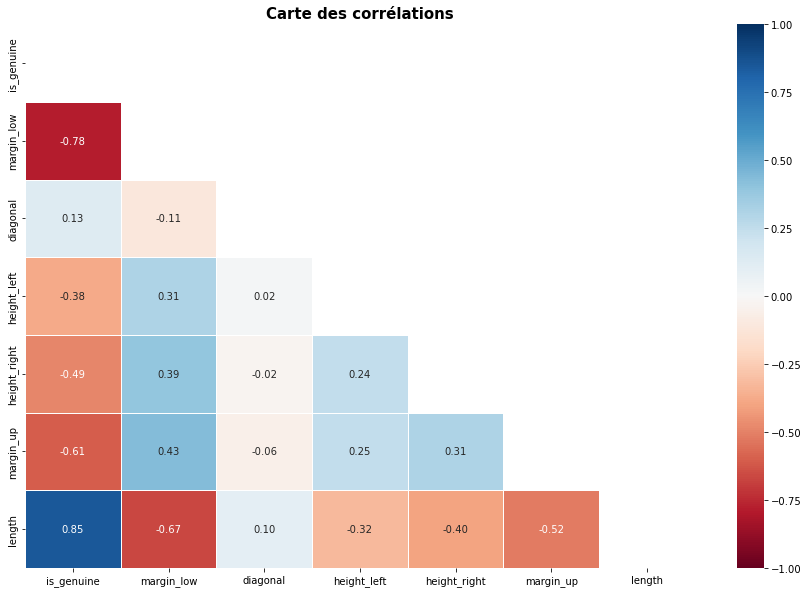

In [38]:
matrice_corr(df)

Nous voyons la forte corrélation entre la variable qualitative et les variables "longueur" et "marge basse".  
Ces 2 variables sont corrélées négativement

# 4. Modélisation<a class='anchor' id='chapter4'></a>

Nous testerons trois types de modélisation : une classification ascendante hiérarchique, un algorithme du K-Means et une Régression Logistique.  
Les dimensions sont dans la même unité (mm) mais il existe des différences d'échelle, il est donc nécessaire de les normaliser.
## 4.1. Normalisation <a class='anchor' id='section4_1'></a>
### 4.1.1. Création de l'objet matrice

In [39]:
X = df.values[:,1:]
names = df["is_genuine"]

X.shape

(1500, 6)

### 4.1.2. Normalisation

In [40]:
# création de l'objet standardiseur
scaler = preprocessing.StandardScaler()
# calcul des données transformées
X_scaled = scaler.fit_transform(X)

In [41]:
df_scaled = pd.DataFrame(X_scaled,columns=df.columns[1:])
df_scaled["is_genuine"] = names
df_scaled

margin_low  diagonal  height_left  height_right  margin_up    length  \
0       0.055382 -0.486540     2.774123      3.163240  -1.128325  0.173651   
1      -1.081976 -1.633729    -2.236535     -0.799668  -0.696799  0.471666   
2      -0.126595  2.397823     1.504756     -1.291191  -0.912562  0.551901   
3      -1.309447 -1.961498    -0.399294      0.060498  -0.610494  0.953075   
4      -0.672527 -0.748754     0.836669     -1.414072   1.417677 -0.158750   
...          ...       ...          ...           ...        ...       ...   
1495    0.859114  0.693427     1.538161     -0.492466  -0.955715 -1.683213   
1496    0.449666  0.398435     0.402412      0.767063   1.072457 -0.445303   
1497    1.890319 -0.781531     1.437948      0.613462   1.978661 -2.714803   
1498    1.071421  2.299493     1.003691      1.504349   1.762898 -1.385197   
1499    0.995597 -0.191548     0.836669      1.135706   0.382015 -1.362273   

      is_genuine  
0           True  
1           True  
2           True  
3           True  
4           True  
...          ...  
1495       False  
1496       False  
1497       False  
1498       False  
1499       False  

[1500 rows x 7 columns]

## 4.2. Analyse en Composantes Principales<a class='anchor' id='section4_2'></a>
Nous commençons notre recherche par une ACP

In [42]:
# création de l'objet pca
pca = decomposition.PCA()
# application de l'ACP aux données standardisées
pca.fit(X_scaled)

PCA()

Nous établissons la courbe des éboulis des valeurs propres. Combinée au critère de Kaiser,nous allons pouvoir déterminer le nombre optimal de composantes principales.

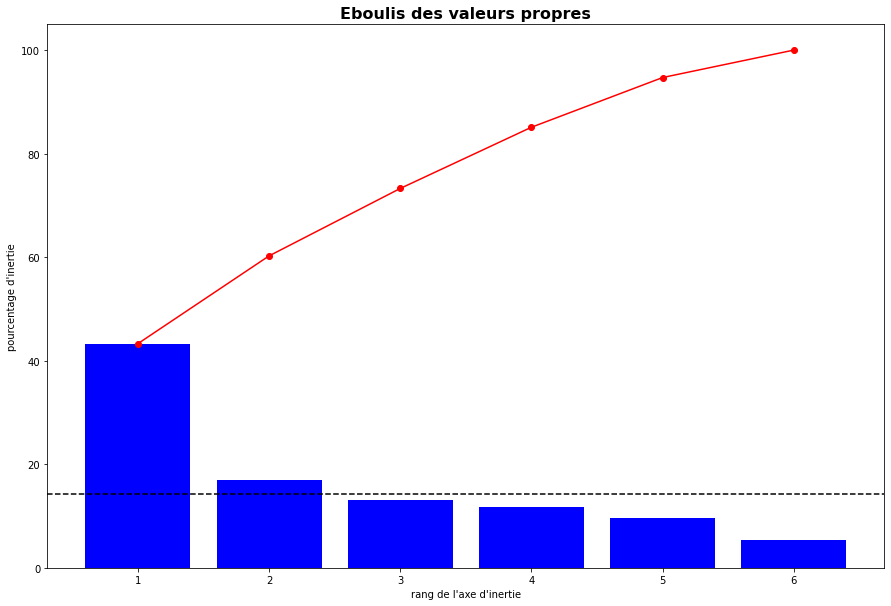

                                     1          2         3          4  \
Cumul de variance expliquée  43.288388  60.244939  73.27003  85.094986   

                                     5      6  
Cumul de variance expliquée  94.697784  100.0  


In [43]:
# critère de Kaiser
p = len(df.columns)
kaiser = 100 / p
    
display_scree_plot(pca, kaiser)

In [44]:
# création de l'objet PCA (2 composantes)
pca2 = decomposition.PCA(n_components=2)
# application de l'ACP aux données standardisées
X_trans = pca2.fit_transform(X_scaled)
# création d'un Dataframe à 2 variables
df_trans = pd.DataFrame(X_trans, index=names, columns=['1e CP', '2e CP'])
df_trans

1e CP     2e CP
is_genuine                    
True        1.644104  0.747792
True       -2.019920 -2.207480
True       -0.969838  2.620523
True       -1.377480 -1.818400
True        0.148718 -0.566777
...              ...       ...
False       1.159393  0.933055
False       1.335433  0.522331
False       4.043061 -0.505810
False       2.777827  2.482406
False       2.131126  0.059742

[1500 rows x 2 columns]

Projection des individus selon les 2 composantes principales:

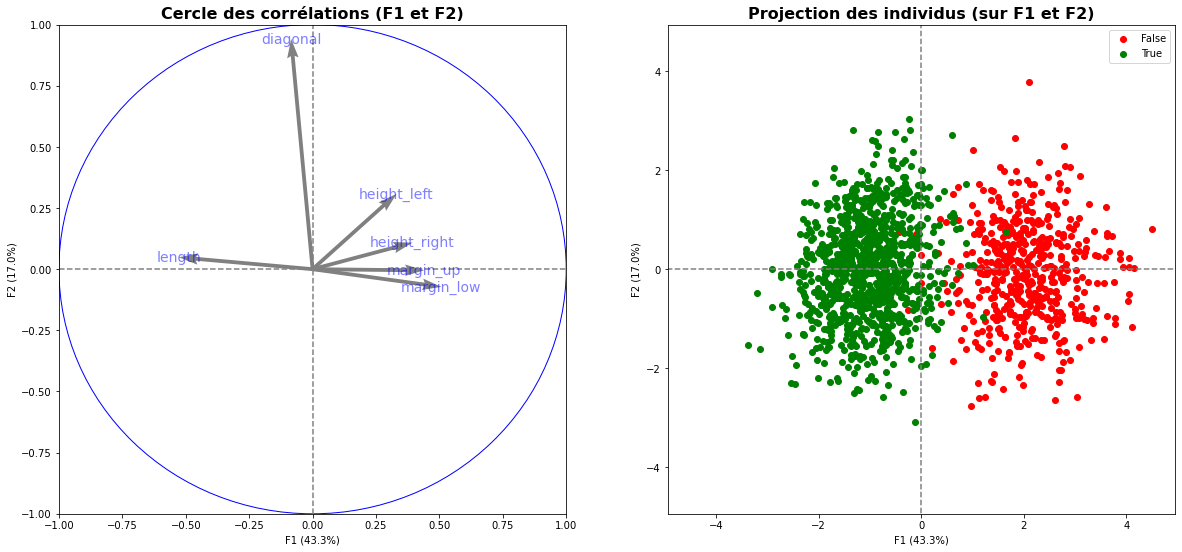

In [45]:
# calcul des différentes composantes
pcs = pca2.components_
#nombre de composantes principales retenues
n_comp = 2
# projection de X sur les composantes principales
X_projected = pca.transform(X_scaled)

# visualisation cercle des corrélations et projection des individus
plt.figure(figsize=(20,9))
plt.subplot(1, 2, 1)
display_circles(pcs, n_comp, pca2, [(0, 1)], labels = np.array(df_scaled.columns))
plt.subplot(1, 2, 2)
display_factorial_planes (X_projected, n_comp, pca2, [(0,1)], illustrative_var = names, labels=None)

La 1e CP permet de différencier vrais et faux billets: négativement par la longueur et positivement par les marges.   
Une valeur positive de la 1e CP semble caractériser un faux billet.  
La 2e CP est fortement influencée par la valeur de la diagonale.
## 4.3. Classification Ascendante Hiérarchique<a class='anchor' id='section4_3'></a>
### 4.3.1. Mise en œuvre
Pour performer une CAH, nous avons besoin d'importer 3 fonctions du module Scipy

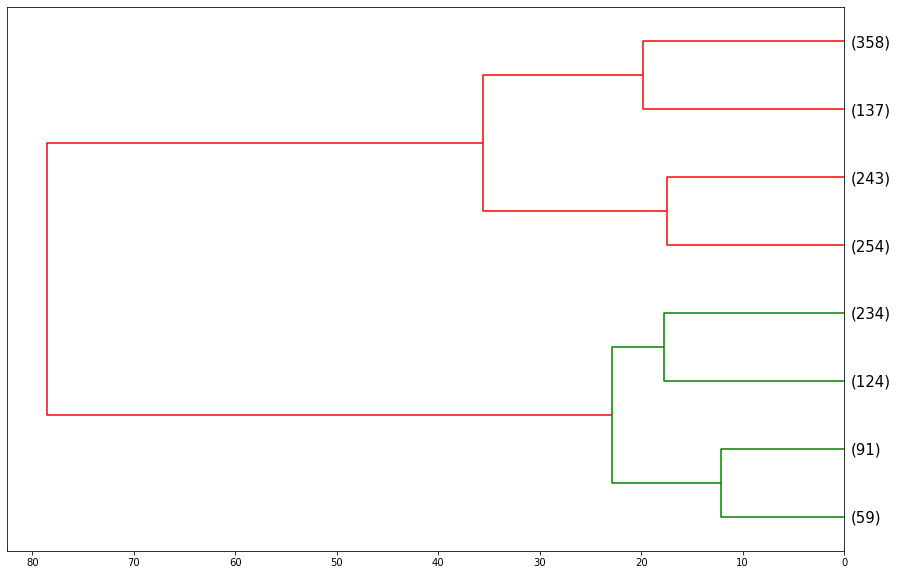

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
    
Z = linkage(X_trans, 'ward')

dendrogram(Z, p=2, truncate_mode='level', leaf_font_size=15, orientation='left');

Nous intégrons les résultats de la CAH dans une copie du dataframe

In [47]:
clusters_CAH = fcluster(Z, 2, criterion='maxclust')

df_CAH = df_trans.copy().reset_index()
df_CAH['Cluster CAH'] = clusters_CAH
df_CAH

is_genuine     1e CP     2e CP  Cluster CAH
0           True  1.644104  0.747792            1
1           True -2.019920 -2.207480            2
2           True -0.969838  2.620523            2
3           True -1.377480 -1.818400            2
4           True  0.148718 -0.566777            1
...          ...       ...       ...          ...
1495       False  1.159393  0.933055            2
1496       False  1.335433  0.522331            1
1497       False  4.043061 -0.505810            1
1498       False  2.777827  2.482406            1
1499       False  2.131126  0.059742            1

[1500 rows x 4 columns]

### 4.3.2. Performance de la CAH

In [48]:
df_CAH.groupby(by="Cluster CAH")["is_genuine"].count()

Cluster CAH
1    508
2    992
Name: is_genuine, dtype: int64

La CAH a prédit 992 billets vrais contre 508 faux. Cette différence de 8 prédictions (taux d'erreur apparent de 0.5%) ne reflète pas la réalité.  
Le numéro de classe peut changer d'une exécution du script à l'autre. Nous utilisons le code suivant pour appliquer la valeur booléenne qui nous intéresse.

In [49]:
a = df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 1].count()
b = df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 2].count()

if  a > b:
    df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 1] = "True"
    df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 2] = "False"
else:
    df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 1] = "False"
    df_CAH["Cluster CAH"][df_CAH["Cluster CAH"] == 2] = "True"

Pour tester notre modèle, nous allons réaliser plusieurs mesures.  
Nous créons 2 objets : les prévisions du modèle et les valeurs observées

In [50]:
y_predCAH = df_CAH["Cluster CAH"].map({"True": 1, "False": 0})
y_true = df_CAH["is_genuine"].astype(int)

Nous commençons par créer une matrice de confusion (prédictions en colonne, valeurs réelles en lignes)

In [51]:
confusion_matrix_CAH = metrics.confusion_matrix(y_true, y_predCAH)
confusion_matrix_CAH = pd.DataFrame(confusion_matrix_CAH, index=["Faux Billets", "Vrais Billets"], columns=["Cluster False", "Cluster True"])
confusion_matrix_CAH

Cluster False  Cluster True
Faux Billets             475            25
Vrais Billets             33           967

Le modèle CAH a mal prédit 58 billets (taux d'erreur 3.9%), ses performances sont mauvaises.  
De la matrice de confusion, nous pouvons déduire plusieurs choses :
> le nombre de vrais positifs TP  
> le nombre de vrais négatifs TN  
> le nombre de faux positifs FP (erreurs de type 1)  
> le nombre de faux négatifs FN (erreurs de type 2)

Nous pouvons calculer la précision du modèle :

In [52]:
# accuracy = (TN + TP) / (TP + FP + TN + FN)
accuracy_CAH = metrics.accuracy_score(y_true, y_predCAH) * 100
print("Précision :", round(accuracy_CAH, 1), "%")

# recall = TP / (TP + FN)
recall_CAH = metrics.recall_score(y_true, y_predCAH) * 100
print("Rappel :", round(recall_CAH,1), "%")

Précision : 96.1 %
Rappel : 96.7 %


Lorsqu'il y a un déséquilibre de classe, la précision globale n'est pas une bonne métrique d'évaluation de la performance.  
Nous allons calculer la valeur du F1 score (moyenne harmonique de la spécificité (*precision*) et de la sensibilité(*recall*))

In [53]:
# F1 = 2 * precision * recall / (precision + recall)
f1_CAH = metrics.f1_score(y_true, y_predCAH) * 100
print("F1-score :", round(f1_CAH, 2), "%")

F1-score : 97.09 %


### 4.3.3. Courbe ROC

L'aire sous la courbe ROC est de 0.958


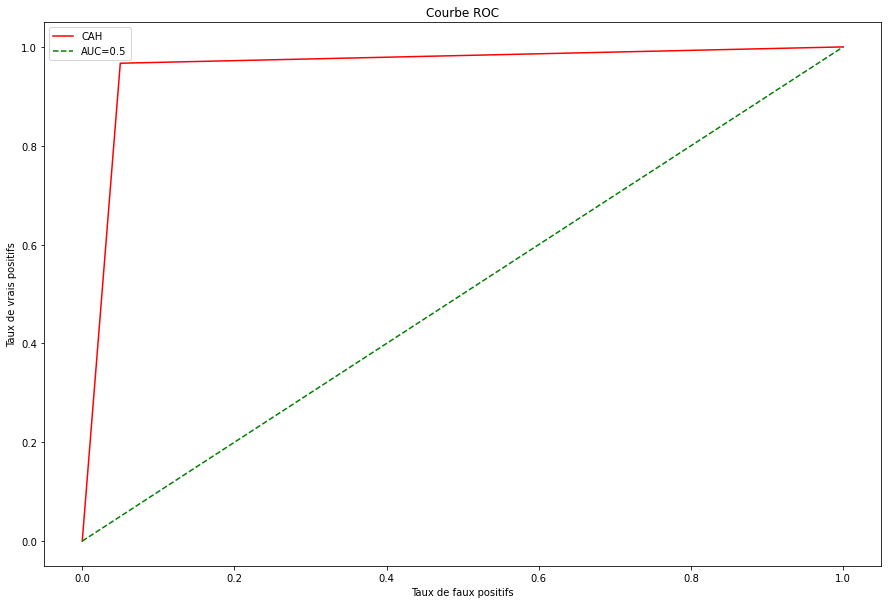

In [54]:
fp, tp, seuil = metrics.roc_curve(y_true, y_predCAH)
plt.plot(fp, tp, label="CAH")
plt.plot([0, 1], [0, 1], label='AUC=0.5', linestyle='--')
plt.xlabel ("Taux de faux positifs")
plt.ylabel ("Taux de vrais positifs")
plt.title('Courbe ROC')
plt.legend();
print("L'aire sous la courbe ROC est de", round(metrics.roc_auc_score(y_true, y_predCAH), 3))

Nous utiliserons la même méthodologie pour tester les autres modélisations.  
Nous pouvons définir une fonction

In [55]:
def confusion(y_true, y_pred):
    
    # calcul de la matrice de confusion
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix, index = ['Real -', 'Real +'], columns=['Prédiction -', 'Prédiction +'])
    print(confusion)
    
    # performances du modèle : accuracy, recall, f1-score et aire sous la courbe ROC
    accuracy = metrics.accuracy_score(y_true, y_pred) * 100
    print("la précision globale de notre modèle est de :", round(accuracy, 1), "%")
    recall = metrics.recall_score(y_true, y_pred) * 100
    print("Rappel :", round(recall,1), "%")
    f1 = metrics.f1_score(y_true, y_pred) * 100
    print("Le F1-score de notre modèle est de ", round(f1, 2), "%")
    print("L'aire sous la courbe ROC est de", round(metrics.roc_auc_score(y_true, y_pred), 2))
    
    # courbe ROC
    fp, tp, seuil = metrics.roc_curve(y_true, y_pred)
    plt.plot(fp, tp, label="Courbe ROC")
    plt.plot([0, 1], [0, 1], label='AUC=0.5', linestyle='--')
    plt.xlabel ("Taux de faux positifs")
    plt.ylabel ("Taux de vrais positifs")
    plt.title('Courbe ROC')
    plt.legend()
    plt.show();
    

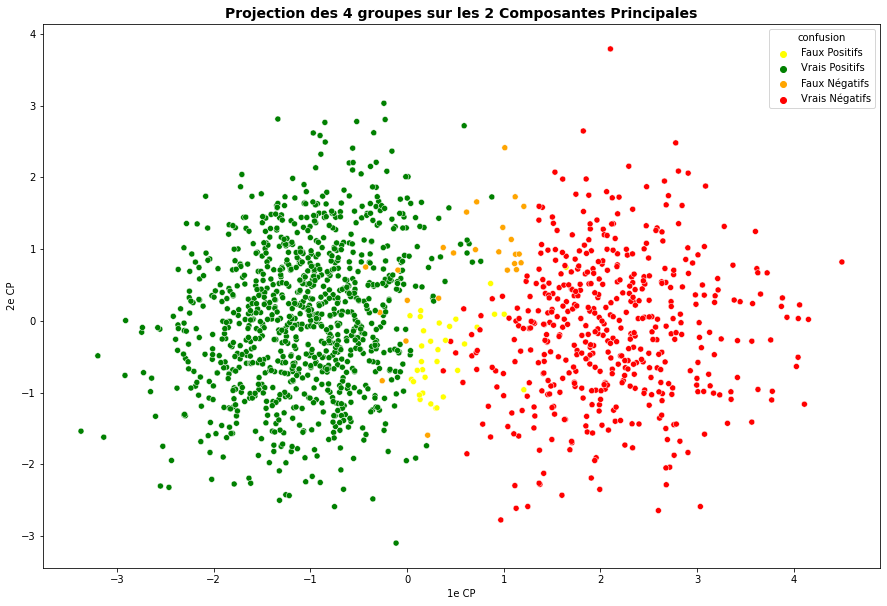

In [56]:
df_CAH["confusion"] = df_CAH["is_genuine"].astype(str) + df_CAH["Cluster CAH"].astype(str)
df_CAH["confusion"] = df_CAH["confusion"].map({"TrueFalse": "Faux Positifs", "TrueTrue": "Vrais Positifs",
                                             "FalseFalse": "Vrais Négatifs", "FalseTrue": "Faux Négatifs"})
                                             
couleurs = {'Faux Positifs': 'Yellow', 'Vrais Positifs': 'Green', 'Vrais Négatifs': 'Red', 'Faux Négatifs': 'Orange'}
sns.scatterplot(data = df_CAH, x = '1e CP', y = '2e CP', hue='confusion', palette=couleurs)
plt.title("Projection des 4 groupes sur les 2 Composantes Principales", fontsize=14, fontweight='bold');

## 4.4. Algorithme du K-Means<a class='anchor' id='section4_4'></a>
### 4.4.1. Détermination du nombre de clusters

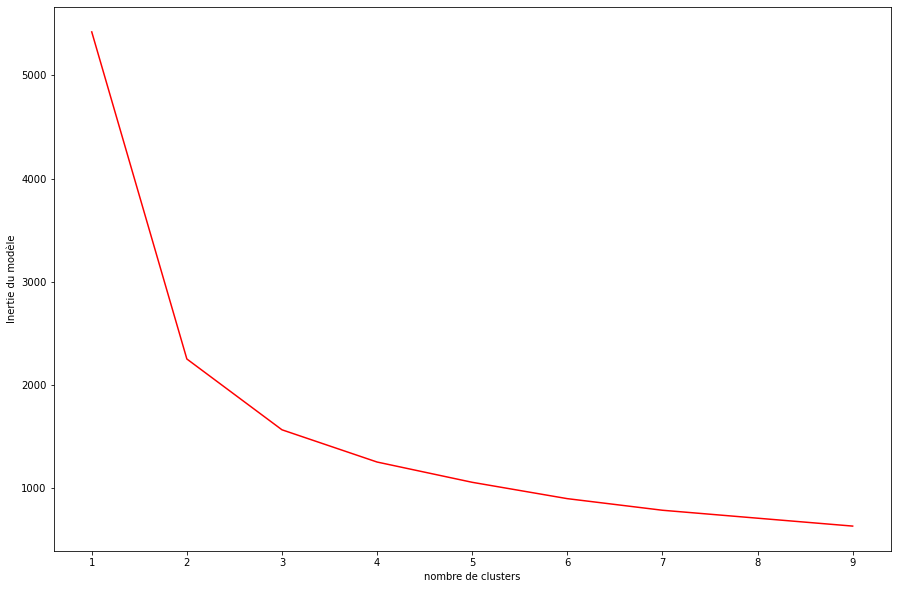

In [57]:
from sklearn.cluster import KMeans

inertie = []

for k in range(1,10):
    model=cluster.KMeans(n_clusters=k).fit(X_trans)
    inertie.append(model.inertia_)
    
plt.plot(range(1,10),inertie)
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie du modèle')
plt.show();

In [58]:
from kneed import KneeLocator

kl = KneeLocator (range(1, 10), inertie, curve="convex", direction="decreasing")
print('Le nombre optimal de clusters est de', kl.elbow)

Le nombre optimal de clusters est de 3


2         3         4         5         6  \
coefficient de silhouette  0.537208  0.422405  0.371553  0.343655  0.341009   

                                  7         8         9  
coefficient de silhouette  0.333155  0.327454  0.322968

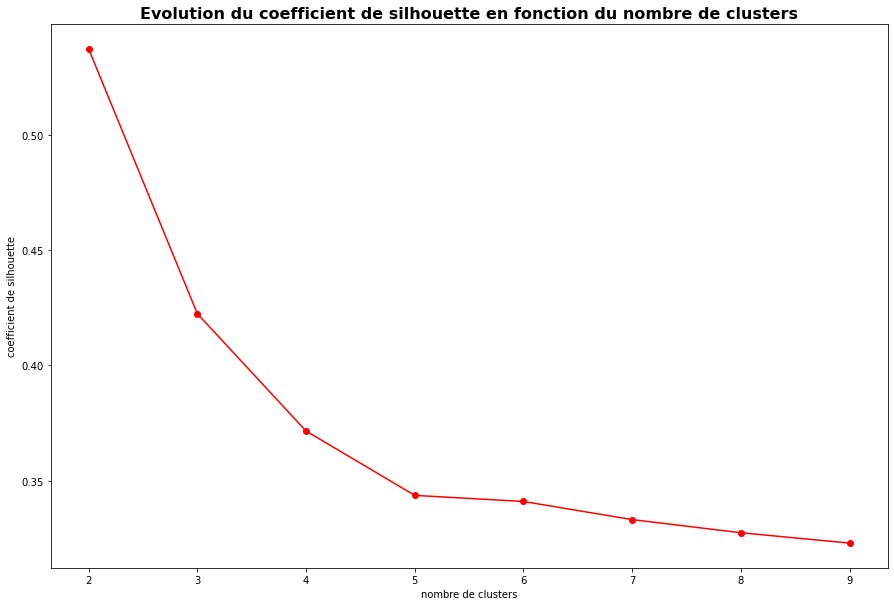

In [59]:
silhouette = []
k_range = range(2, 10)
for num_cls in range(2, 10):
    modelkm = KMeans(n_clusters = num_cls)
    modelkm.fit_predict(X_trans)
    cluster_labels = modelkm.fit_predict(X_trans)
    silh = metrics.silhouette_score(X_trans, cluster_labels)
    silhouette.append(silh)

plt.plot(range(2, 10), silhouette, marker = 'o')
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.title('Evolution du coefficient de silhouette en fonction du nombre de clusters', fontsize=16, fontweight='bold')
plt.show
silhouette = pd.DataFrame(silhouette, index = np.arange(2, 10), columns=['coefficient de silhouette']).T
silhouette

### 4.4.2. Mise en oeuvre du K-Means

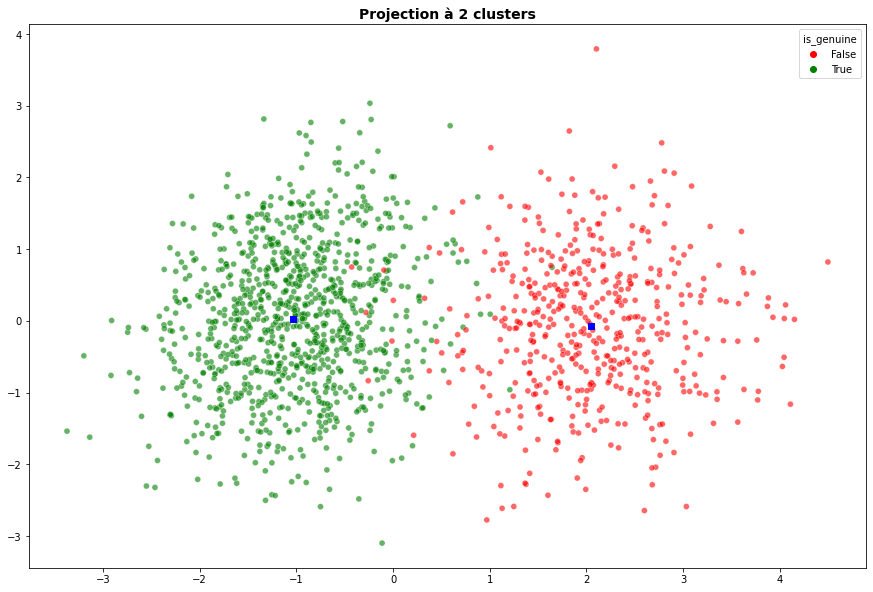

In [60]:
km = cluster.KMeans(n_clusters=2)
modelkm = km.fit_predict(X_trans)
centroid = km.cluster_centers_

sns.scatterplot(X_trans[:,0],X_trans[:,1], hue=df_trans.index, palette=colours, alpha=0.6)
plt.scatter(centroid[:,0], centroid[:,1], marker='s', c='blue')
plt.title('Projection à 2 clusters', fontsize=14, fontweight='bold');

Nous ajoutons le numéro de cluster déterminé par le K-Means

In [61]:
df_KM = df_trans.copy().reset_index()
df_KM['Cluster KM'] = km.labels_
df_KM

is_genuine     1e CP     2e CP  Cluster KM
0           True  1.644104  0.747792           0
1           True -2.019920 -2.207480           1
2           True -0.969838  2.620523           1
3           True -1.377480 -1.818400           1
4           True  0.148718 -0.566777           1
...          ...       ...       ...         ...
1495       False  1.159393  0.933055           0
1496       False  1.335433  0.522331           0
1497       False  4.043061 -0.505810           0
1498       False  2.777827  2.482406           0
1499       False  2.131126  0.059742           0

[1500 rows x 4 columns]

### 4.4.3. Analyse des performances du K-Means
Nous comptons le nombre de vrais et de faux billets déterminés par le K-Means :

In [62]:
df_KM.groupby(by="Cluster KM")["is_genuine"].count()

Cluster KM
0    503
1    997
Name: is_genuine, dtype: int64

Le K-means a prédit 997 billets vrais et 503 billets faux.  
Sans autre analyse, nous pourrions être amenés à penser que seuls 3 vrais billets ont été prédits faux (taux d'erreur apparent de 0.2%).
 
Le numéro de classe peut changer d'une exécution du script à l'autre. Nous utilisons le code suivant pour appliquer la valeur booléenne qui nous intéresse.

In [63]:
a = df_KM["Cluster KM"][df_KM["Cluster KM"] == 0].count()
b = df_KM["Cluster KM"][df_KM["Cluster KM"] == 1].count()

if  a > b:
    df_KM["Cluster KM"][df_KM["Cluster KM"] == 0] = "True"
    df_KM["Cluster KM"][df_KM["Cluster KM"] == 1] = "False"
else:
    df_KM["Cluster KM"][df_KM["Cluster KM"] == 0] = "False"
    df_KM["Cluster KM"][df_KM["Cluster KM"] == 1] = "True"

Nous créons nos 2 objets y_true (identique à celui de la CAH) et y_pred

In [64]:
y_predKM = df_KM["Cluster KM"].map({"True": 1, "False": 0})
y_true = df_KM["is_genuine"].astype(int) # identique CAH

Celà nous permet d'établir la matrice de confusion du modèle K-Means, de calculer la précision et le f1-score, et de tracer la courbe ROC :

        Prédiction -  Prédiction +
Real -           488            12
Real +            15           985
la précision globale de notre modèle est de : 98.2 %
Rappel : 98.5 %
Le F1-score de notre modèle est de  98.65 %
L'aire sous la courbe ROC est de 0.98


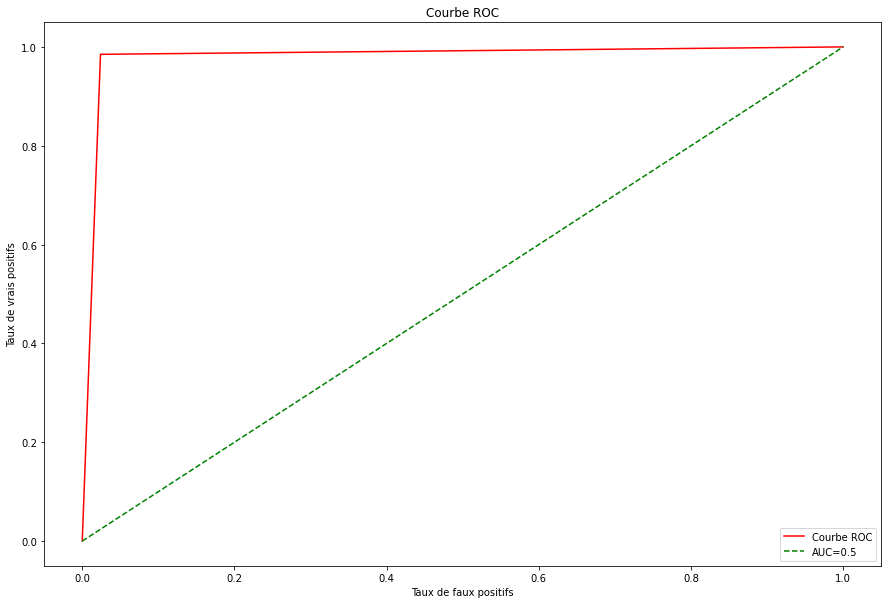

In [65]:
confusion(y_true, y_predKM)

Cette matrice nous permet de voir que les prédictions par la classification K-Means sont meilleures, 27 billets n'ont pas été bien classifiés (taux d'erreur de 1.8%).  
Les valeurs de la précision et du f1-score en font un meilleur modèle que la CAH.

### 4.4.4. Visualisation des 4 groupes

Nous ajoutons à notre nuage de points les nuances faux négatifs et faux positifs.  
Pour cela, nous créons une nouvelle colonne faisant la concaténation des valeurs de "is_genuine" et "cluster KM", passés en chaîne de caractère (le type booléen ne permettant pas le résultat souhaité).  Nous transformons ensuite les résultats obtenus pour qu'ils soient compréhensibles.

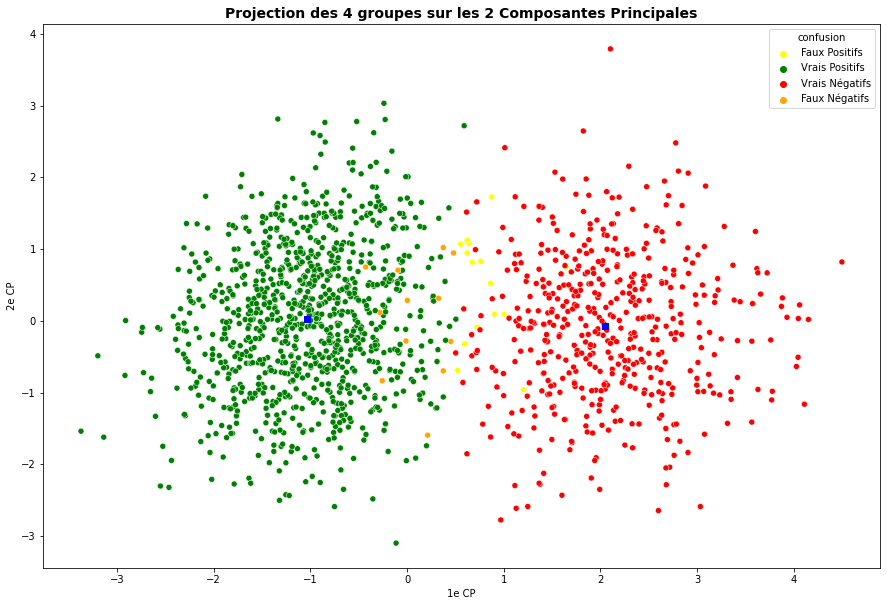

In [66]:
# ajout d'une colonne "confusion"
df_KM["confusion"] = df_KM["is_genuine"].astype(str) + df_KM["Cluster KM"].astype(str)

# transformation des termes concaténés
df_KM["confusion"] = df_KM["confusion"].map({"TrueFalse": "Faux Positifs", "TrueTrue": "Vrais Positifs",
                                             "FalseFalse": "Vrais Négatifs", "FalseTrue": "Faux Négatifs"})

# définition d'une palette de 4 couleurs
couleurs = {'Faux Positifs': 'Yellow', 'Vrais Positifs': 'Green', 'Vrais Négatifs': 'Red', 'Faux Négatifs': 'Orange'}

sns.scatterplot(data = df_KM, x = '1e CP', y = '2e CP', hue='confusion', palette=couleurs)
plt.scatter(centroid[:,0], centroid[:,1], marker='s', c='blue')
plt.title("Projection des 4 groupes sur les 2 Composantes Principales", fontsize=14, fontweight='bold');

## 4.5. Régression logistique<a class='anchor' id='section4_5'></a>
### 4.5.1. Préparation des données

Nous reprenons notre df pour y appliquer une régression logistique sur la variable "is_genuine" pour qu'elle soit ensuite prédite par les variables quantitatives.  
Nous transformons notre colonne "is_genuine" : 1 pour True et 0 pour False

In [67]:
df_reg = df.copy()
df_reg["is_genuine"] = df_reg["is_genuine"].astype(int)
df_reg

is_genuine  margin_low  diagonal  height_left  height_right  margin_up  \
0              1        4.52    171.81       104.86        104.95       2.89   
1              1        3.77    171.46       103.36        103.66       2.99   
2              1        4.40    172.69       104.48        103.50       2.94   
3              1        3.62    171.36       103.91        103.94       3.01   
4              1        4.04    171.73       104.28        103.46       3.48   
...          ...         ...       ...          ...           ...        ...   
1303           0        5.05    172.17       104.49        103.76       2.93   
1315           0        4.78    172.08       104.15        104.17       3.40   
1347           0        5.73    171.72       104.46        104.12       3.61   
1435           0        5.19    172.66       104.33        104.41       3.56   
1438           0        5.14    171.90       104.28        104.29       3.24   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49  

[1500 rows x 7 columns]

Nous séparons notre dataset en 2 parties : une partie pour l'entraînement de notre modèle, l'autre pour tester notre modèle.

In [68]:
from sklearn.model_selection import train_test_split

y = df_reg["is_genuine"]
seed = 42

X_train, X_test = train_test_split(df_reg, test_size = 0.25, random_state = seed, stratify=y)
# stratify permet de s'assurer d'avoir les mêmes proportions de vrais/faux dans chaque groupe

### 4.5.2. Mise en oeuvre de la Régression
Nous appliquons la régression logistique sur X_train :

In [69]:
reg_logit = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+margin_up+length', data=X_train,
                    family=sm.families.Binomial()).fit()
reg_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1118
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.800
Date:                Thu, 01 Sep 2022   Deviance:                       65.599
Time:                        14:09:50   Pearson chi2:                 2.78e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7032
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -99.2514    265.735     -0.373      0.709    -620.082     421.579
diagonal        -0.7023      1.212     -0.580      0.562      -3.077       1.672
height_left     -1.7758      1.223     -1.452      0.147      -4.173       0.622
height_right    -1.9310      1.282     -1.507      0.132      -4.443       0.581
margin_low      -5.9063      1.094     -5.397      0.000      -8.051      -3.761
margin_up      -10.5275      2.502     -4.207      0.000     -15.432      -5.623
length           5.9237      0.967      6.123      0.000       4.028       7.820
================================================================================
"""

la p-value de la variable "diagonal" est très largement supérieure à notre seuil de 5% et elle n'est pas très significative. Nous la retirons donc

In [70]:
reg_logit = smf.glm('is_genuine ~ height_left+height_right+margin_low+margin_up+length', data=X_train, 
                    family=sm.families.Binomial()).fit()
reg_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1119
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.968
Date:                Thu, 01 Sep 2022   Deviance:                       65.935
Time:                        14:09:50   Pearson chi2:                 2.47e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7031
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -201.2766    199.804     -1.007      0.314    -592.884     190.331
height_left     -1.8284      1.227     -1.490      0.136      -4.233       0.576
height_right    -1.9284      1.297     -1.487      0.137      -4.470       0.613
margin_low      -5.6791      0.987     -5.755      0.000      -7.613      -3.745
margin_up      -10.4015      2.477     -4.199      0.000     -15.257      -5.546
length           5.7910      0.911      6.357      0.000       4.006       7.576
================================================================================
"""

Nous procédons de même pour la variable "height_right"...

In [71]:
reg_logit = smf.glm('is_genuine ~ height_left+margin_low+margin_up+length', data=X_train,
                    family=sm.families.Binomial()).fit()
reg_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1120
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34.174
Date:                Thu, 01 Sep 2022   Deviance:                       68.348
Time:                        14:09:50   Pearson chi2:                 5.45e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7025
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -405.5379    153.217     -2.647      0.008    -705.837    -105.239
height_left    -2.1031      1.171     -1.796      0.072      -4.398       0.191
margin_low     -6.0120      0.987     -6.092      0.000      -7.946      -4.078
margin_up     -10.6369      2.367     -4.493      0.000     -15.277      -5.997
length          6.0982      0.918      6.644      0.000       4.299       7.897
===============================================================================
"""

...et avec la variable "height_left".

In [72]:
reg_logit = smf.glm('is_genuine ~ margin_low+margin_up+length', data=X_train,
                    family=sm.families.Binomial()).fit()
reg_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1121
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.891
Date:                Thu, 01 Sep 2022   Deviance:                       71.781
Time:                        14:09:50   Pearson chi2:                 9.16e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7016
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -642.9505     97.301     -6.608      0.000    -833.657    -452.244
margin_low    -6.4157      0.994     -6.451      0.000      -8.365      -4.467
margin_up    -10.9304      2.308     -4.735      0.000     -15.455      -6.406
length         6.2877      0.912      6.895      0.000       4.500       8.075
==============================================================================
"""

In [73]:
print("Les paramètres de notre régression logistique sont :")
for i in range(0,4):
    print("\t Beta", i + 1, " :", reg_logit.params[i])

Les paramètres de notre régression logistique sont :
	 Beta 1  : -642.9504593529169
	 Beta 2  : -6.415686199949103
	 Beta 3  : -10.930433921639835
	 Beta 4  : 6.287675908062335


Nous pouvons tester notre modèle sur X_test

In [74]:
# valeurs prédites
y_pred = reg_logit.predict(X_test)
# valeurs prédites arrondies
y_pred_reg = round(y_pred)
# valeurs réelles
y_true = X_test['is_genuine'].astype(float)

### 4.5.3. Performances du modèle :

        Prédiction -  Prédiction +
Real -           122             3
Real +             1           249
la précision globale de notre modèle est de : 98.9 %
Rappel : 99.6 %
Le F1-score de notre modèle est de  99.2 %
L'aire sous la courbe ROC est de 0.99


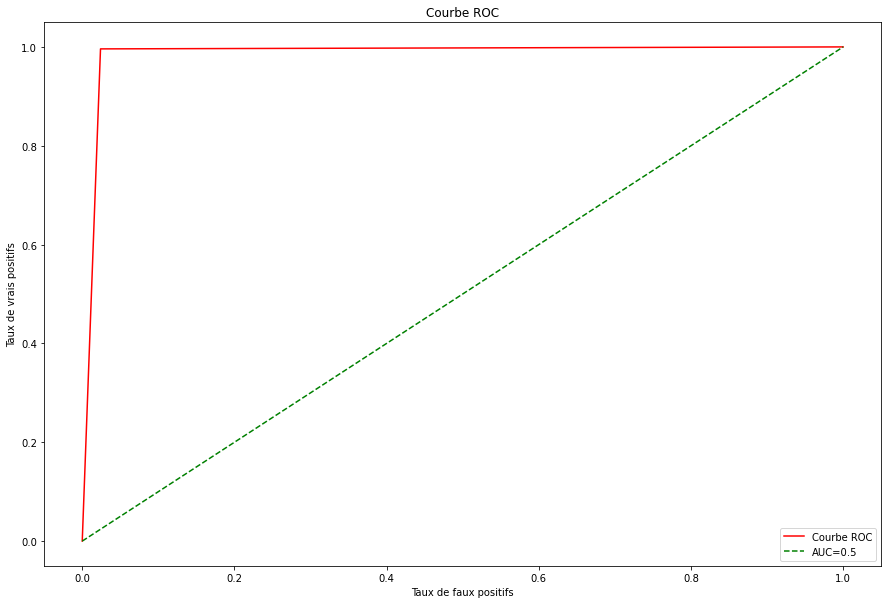

In [75]:
confusion(y_true, y_pred_reg)

### 4.5.4. Tests supplémentaires

In [76]:
X_test["probability"] = y_pred
X_test.loc[(X_test["probability"] < 0.9) & (X_test["probability"] > 0.1)]

is_genuine  margin_low  diagonal  height_left  height_right  margin_up  \
1409           0        4.59    171.90       104.09        104.73       3.27   
1103           0        4.41    171.88       104.05        103.75       3.21   
1307           0        4.49    171.68       104.24        104.00       3.24   
525            1        4.89    171.97       103.61        103.60       3.17   
193            1        4.49    172.35       103.73        102.95       3.37   
985            1        4.12    171.88       103.87        104.02       3.33   
626            1        4.67    171.98       104.44        104.08       3.21   
75             1        4.16    172.26       103.85        103.70       3.20   
1190           0        4.55    171.45       104.21        104.18       3.52   
38             1        4.42    172.00       103.76        104.27       3.29   
1062           0        5.37    171.65       104.19        103.96       2.99   

      length  probability  
1409  112.47     0.275665  
1103  112.52     0.761145  
1307  112.18     0.139432  
525   112.96     0.782999  
193   112.49     0.215550  
985   112.47     0.801147  
626   112.73     0.692386  
75    112.35     0.858548  
1190  113.21     0.770446  
38    112.67     0.761973  
1062  112.86     0.387558

Sur les 375 valeurs de notre échantillon test, 11 ont une probabilité comprise entre 0.1 & 0.9. Nous pouvons identifier les 4 billets que notre modèle a mal prédit :

In [77]:
X_test.loc[(X_test["probability"] < 0.5) & (X_test["is_genuine"] == True)]

is_genuine  margin_low  diagonal  height_left  height_right  margin_up  \
193           1        4.49    172.35       103.73        102.95       3.37   

     length  probability  
193  112.49      0.21555

La valeur de la hauteur droite est inférieure à la moyenne (103.8mm). Ce point faisait partie des valeurs atypiques levier.

In [78]:
X_test.loc[(X_test["probability"] > 0.5) & (X_test["is_genuine"] == False)]

is_genuine  margin_low  diagonal  height_left  height_right  margin_up  \
1103           0        4.41    171.88       104.05        103.75       3.21   
1190           0        4.55    171.45       104.21        104.18       3.52   
1407           0        4.22    172.02       103.99        104.28       2.98   

      length  probability  
1103  112.52     0.761145  
1190  113.21     0.770446  
1407  112.42     0.986118

Les valeurs de la marge basse sont inférieures à la moyenne (5.2mm). Aucun ne faisait partie des valeurs atypiques.

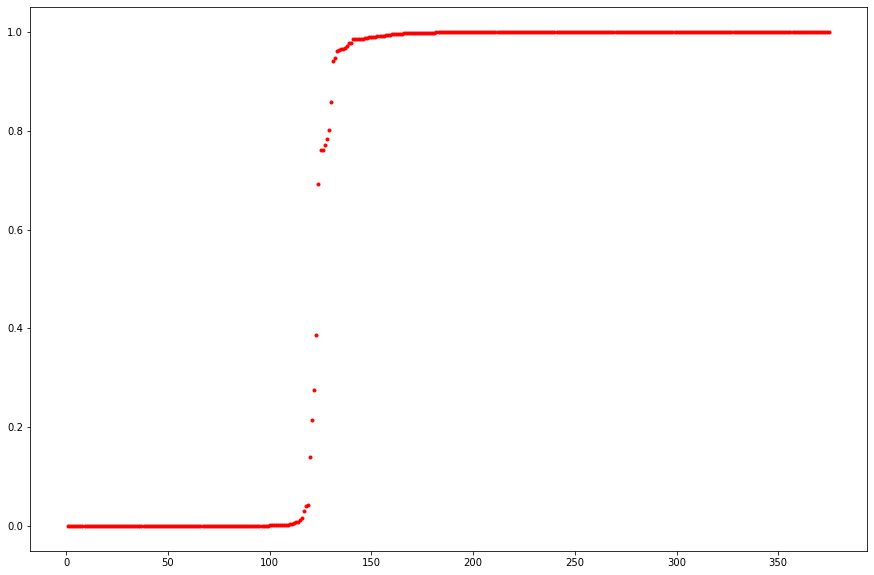

In [80]:
# les valeurs de probabilité sont triées par ordre croissant
X_test = X_test.sort_values(by='probability')
# ajout d'une colonne de rang
X_test.insert(0, 'index', range(1, 1 + len(X_test)))

#visualisation
plt.scatter(data=X_test, x='index', y='probability', marker='.')

### 4.5.5. Projection
Les centroides de chaque groupe seront également projetés.

In [81]:
centroids = X_test.groupby("is_genuine").mean()
centroids

index  margin_low  diagonal  height_left  height_right  \
is_genuine                                                             
0            63.224     5.22088  171.8836    104.17096     104.13304   
1           250.388     4.11508  171.9844    103.94136     103.81768   

            margin_up     length  probability  
is_genuine                                     
0             3.33672  111.60264     0.028178  
1             3.05176  113.19224     0.989867

Nous ajoutons une nouvelle colonne pour indiquer à quel sous-groupe appartient le billet testé.

In [82]:
X_test["Régression"] = y_pred_reg.astype(int)
X_test["confusion"] = X_test["is_genuine"].astype(str) + X_test["Régression"].astype(str)
X_test["confusion"] = X_test["confusion"].map({"00": "Vrais Négatifs", "01": "Faux Négatifs", "10": "Faux Positifs", "11": "Vrais Positifs"})

Nous pouvons projeter nos 4 groupes

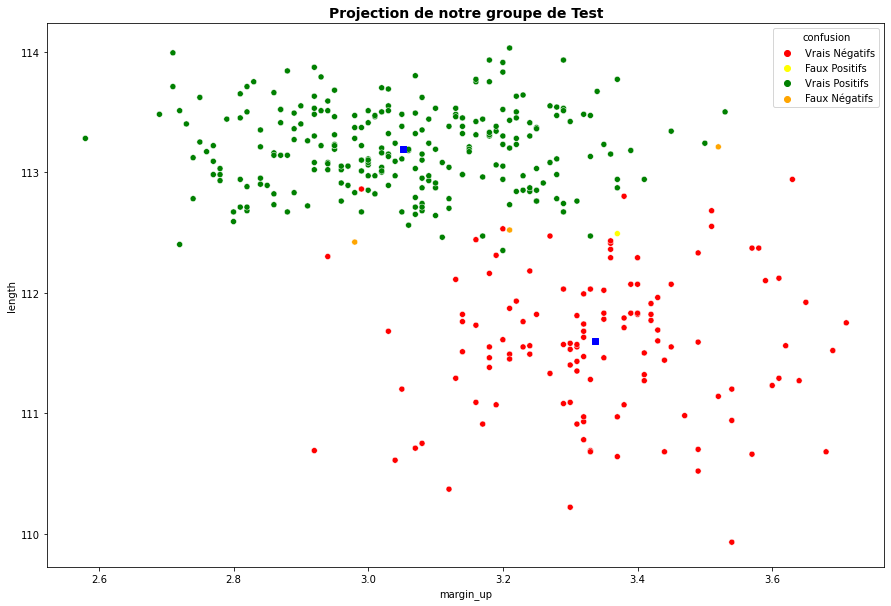

In [83]:
sns.scatterplot(data = X_test, x = 'margin_up', y = 'length', hue='confusion', palette=couleurs)
plt.scatter(data=centroids, x = 'margin_up', y = 'length', marker='s', c='blue')
plt.title("Projection de notre groupe de Test", fontsize=14, fontweight='bold');

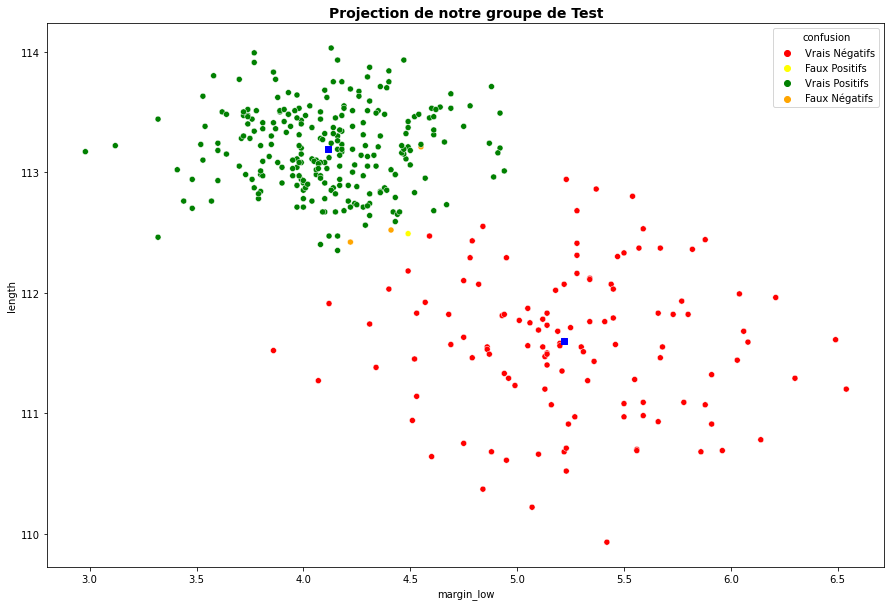

In [84]:
sns.scatterplot(data = X_test, x = 'margin_low', y = 'length', hue='confusion', palette=couleurs)
plt.scatter(data=centroids, x = 'margin_low', y = 'length', marker='s', c='blue')
plt.title("Projection de notre groupe de Test", fontsize=14, fontweight='bold');

Visualisation selon les 3 dimensions retenues par la régression

In [85]:
# création des 4 groupes
fn = X_test[X_test["confusion"] == "Faux Négatifs"]
tn = X_test[X_test["confusion"] == "Vrais Négatifs"]
fp = X_test[X_test["confusion"] == "Faux Positifs"]
tp = X_test[X_test["confusion"] == "Vrais Positifs"]

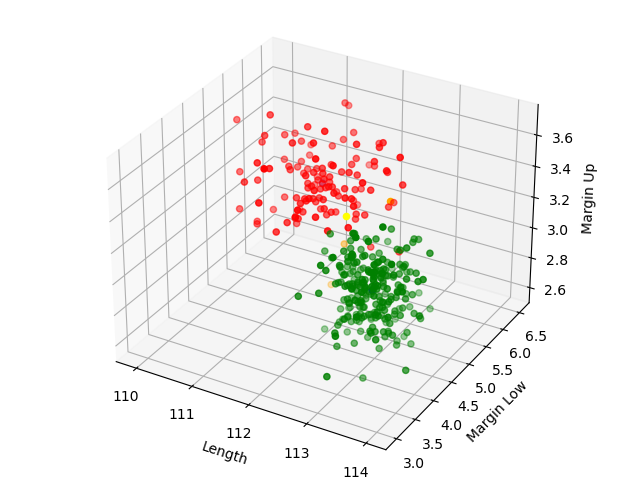

In [86]:
# création d'une figure interactive
%matplotlib widget
  
# import de la librairie
from mpl_toolkits.mplot3d import Axes3D

# création de la figure
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(centroids["length"], centroids["margin_low"], centroids["margin_up"], c='blue')
ax.scatter(fn["length"], fn["margin_low"], fn["margin_up"], c='orange')
ax.scatter(tn["length"], tn["margin_low"], tn["margin_up"], c='red')
ax.scatter(fp["length"], fp["margin_low"], fp["margin_up"], c='yellow')
ax.scatter(tp["length"], tp["margin_low"], tp["margin_up"], c='green')
ax.set_xlabel("Length")
ax.set_ylabel("Margin Low")
ax.set_zlabel("Margin Up")
plt.show();

# 5. Sauvegarde du modèle retenu<a class='anchor' id='chapter5'></a>

In [87]:
'''from joblib import dump

dump(reg_logit, 'model_billets.joblib')'''

"from joblib import dump\n\ndump(reg_logit, 'model_billets.joblib')"

# 6. Mise en service du modèle de Régression Logistique<a class='anchor' id='chapter6'></a>

In [88]:
from joblib import load

model = load('model_billets.joblib')

## Test des billets
Nous créons une fonction qui importe les fichiers au format csv et applique le modèle aux données qu'il contient.  
En retour, le fichier est complété par la prédiction d'authenticité et la valeur de la probabilité de prédiction

In [89]:
def prediction_billet(csv) :
    df_a_tester = pd.read_csv(csv, index_col="id")
    df_a_tester.insert(0, "is_genuine", np.nan)
    prediction = model.predict(df_a_tester)
    df_a_tester["probabilité de prédiction"] = prediction
    df_a_tester['is_genuine'] = round(prediction,0).astype(bool)
    return df_a_tester

Nous pouvons tester notre fonction sur notre jeu de données test :

In [90]:
prediction_billet("billets_production.csv")

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
id                                                                            
A_1       False    171.76       104.01        103.54        5.21       3.30   
A_2       False    171.87       104.17        104.13        6.00       3.31   
A_3       False    172.00       104.58        104.29        4.99       3.39   
A_4        True    172.49       104.55        104.34        4.44       3.03   
A_5        True    171.65       103.63        103.56        3.77       3.16   

     length  probabilité de prédiction  
id                                      
A_1  111.42                   0.000007  
A_2  112.09                   0.000003  
A_3  111.57                   0.000027  
A_4  113.20                   0.999261  
A_5  113.33                   0.999982

In [96]:
prediction_billet("billets_test.csv")

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
id                                                                            
B_1        True    172.09       103.95        103.73        4.39       3.09   
B_2       False    171.52       104.17        104.03        5.27       3.16   
B_3        True    171.78       103.80        103.75        3.81       3.24   
B_4       False    172.02       104.08        103.99        5.57       3.30   
B_5       False    171.79       104.34        104.37        5.00       3.07   

     length  probabilité de prédiction  
id                                      
B_1  113.19               9.989004e-01  
B_2  111.82               2.709306e-04  
B_3  113.39               9.999610e-01  
B_4  111.10               9.255432e-08  
B_5  111.87               5.579735e-03

Le Notebook suivant montre d'autres possibilités de mise en service